# Wind and solar risk profiles

Analyses of individual generators' dispatch-weighted average prices, curtailment and underperformance.

In [1]:
# Data handling
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import pyarrow.compute as pc

# Visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Custom functions
from scripts.common_functions import python_setup, get_mms_data, save_figure

# Set up Python
working_dir, charts_dir, data_dir = python_setup(2, dark_mode=False)

In [2]:
# Prepare data
gen_info_path = os.path.join(data_dir, "gen_info.csv")
duid_data_path = os.path.join(data_dir, "duid_data.parquet")
market_data_path = os.path.join(data_dir, "market_data.parquet")

gen_info = pd.read_csv(
    gen_info_path,
    index_col="DUID")

regions = ["NSW", "QLD", "SA", "VIC"]

Preparing NSW dispatch-weighted average prices ...


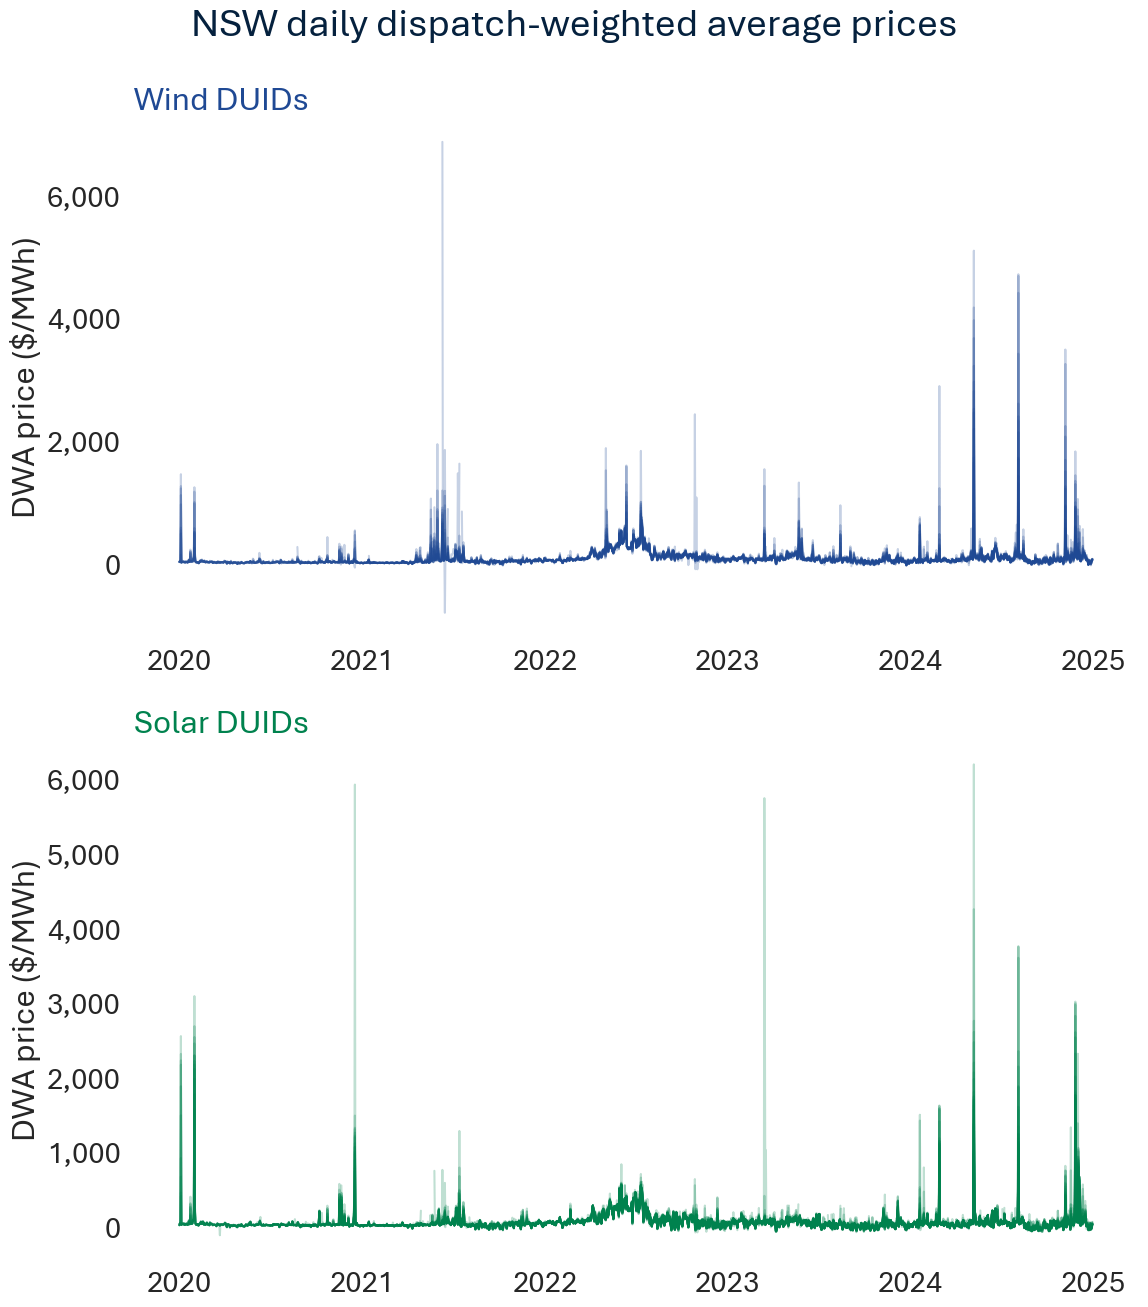

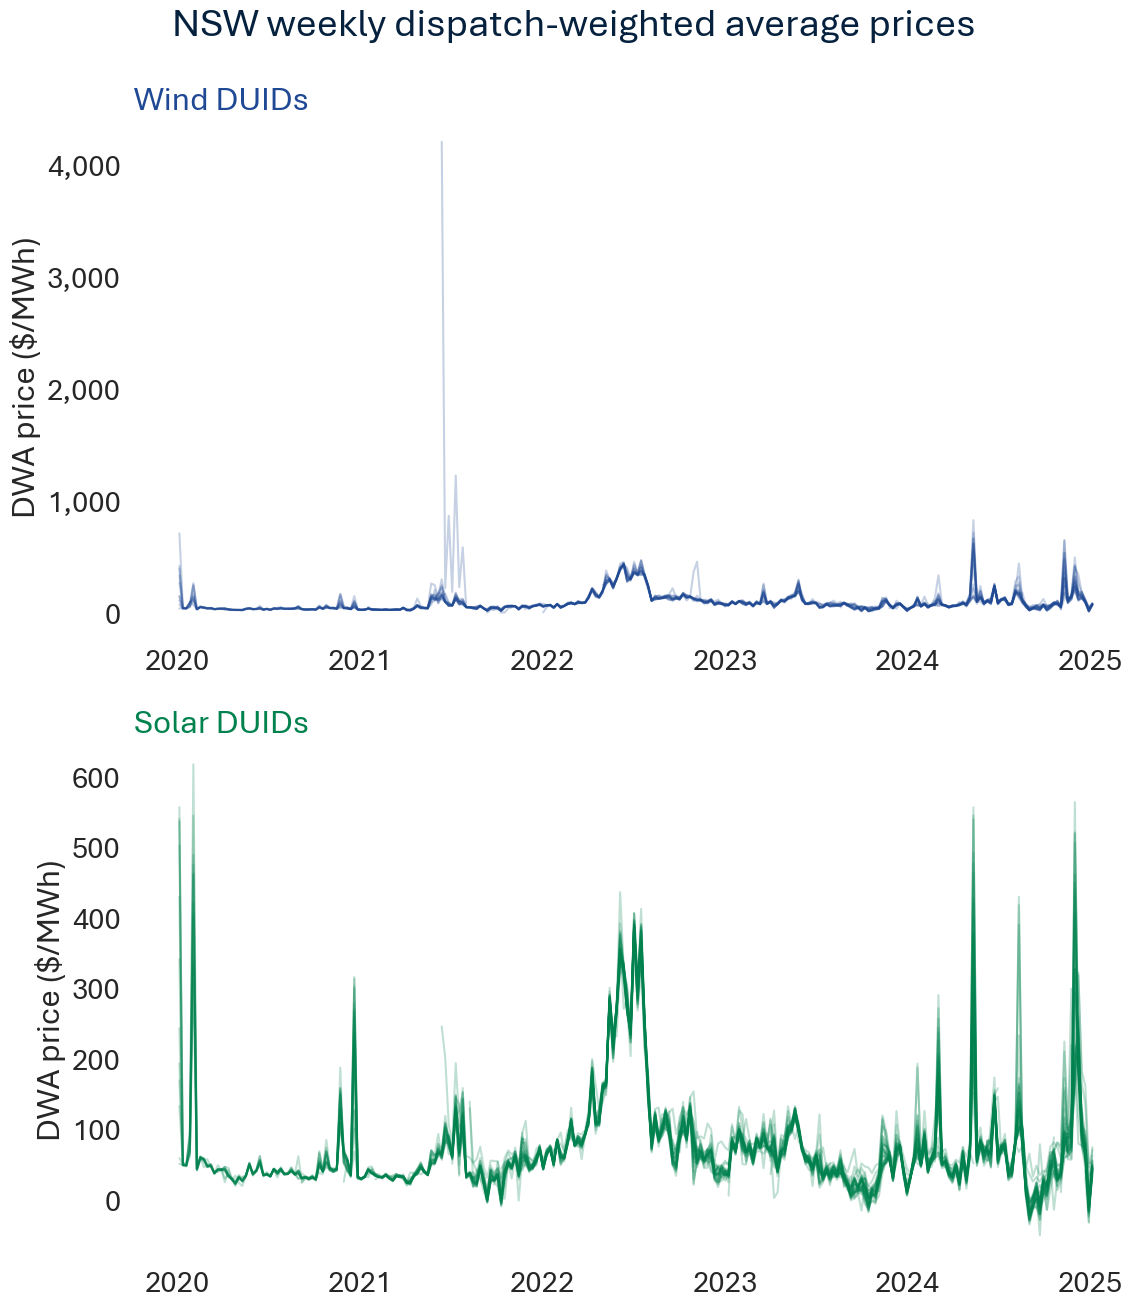

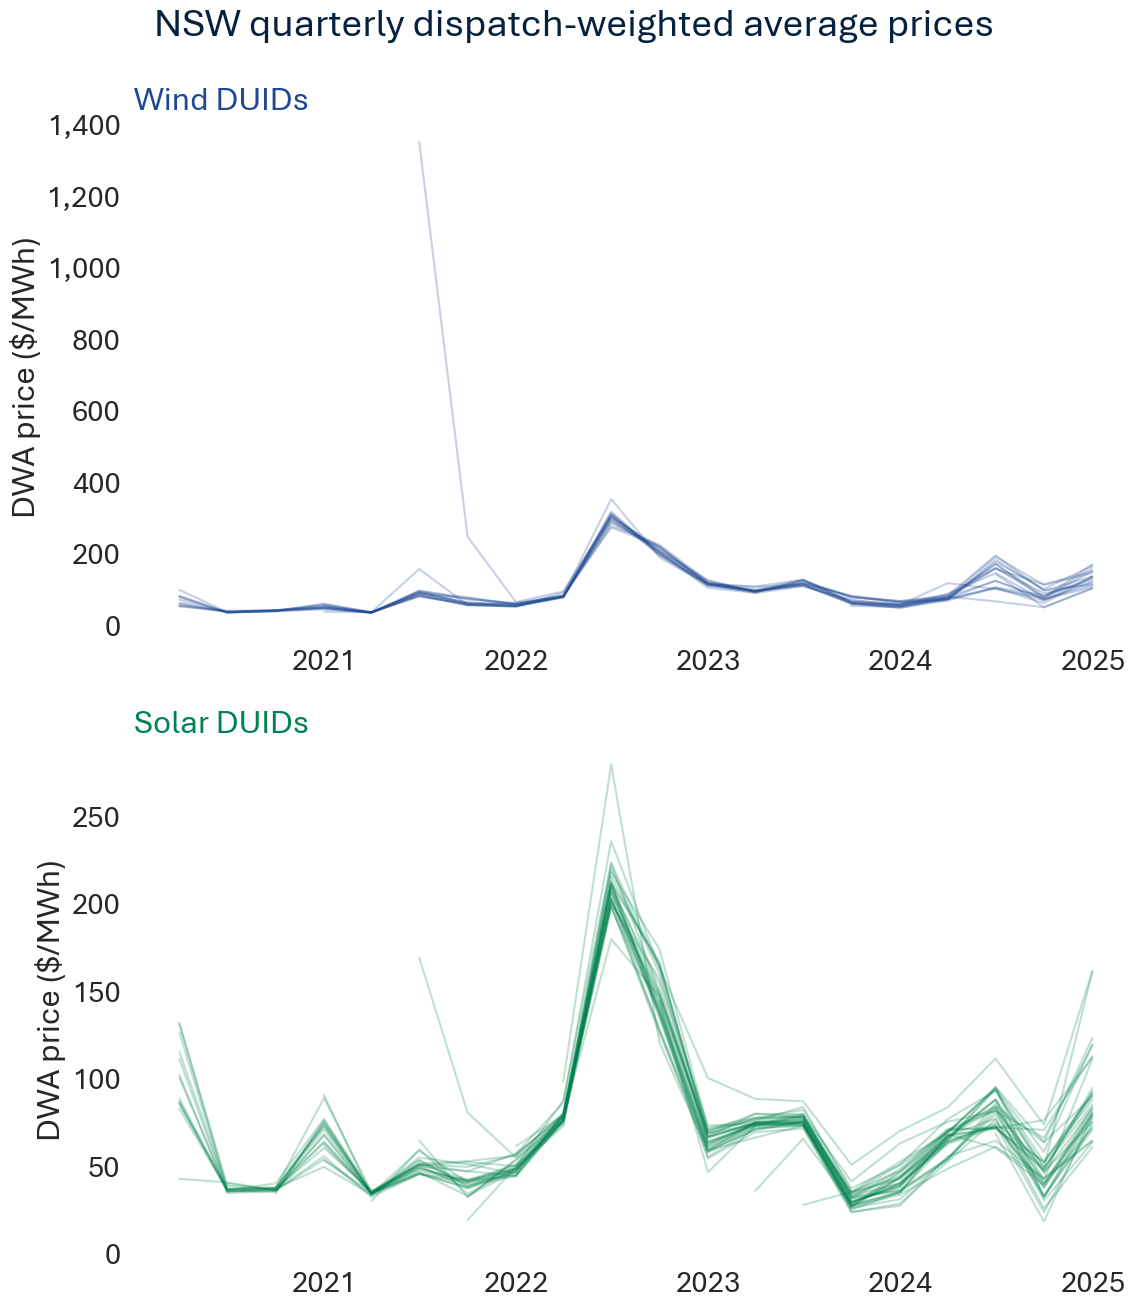

Preparing QLD dispatch-weighted average prices ...


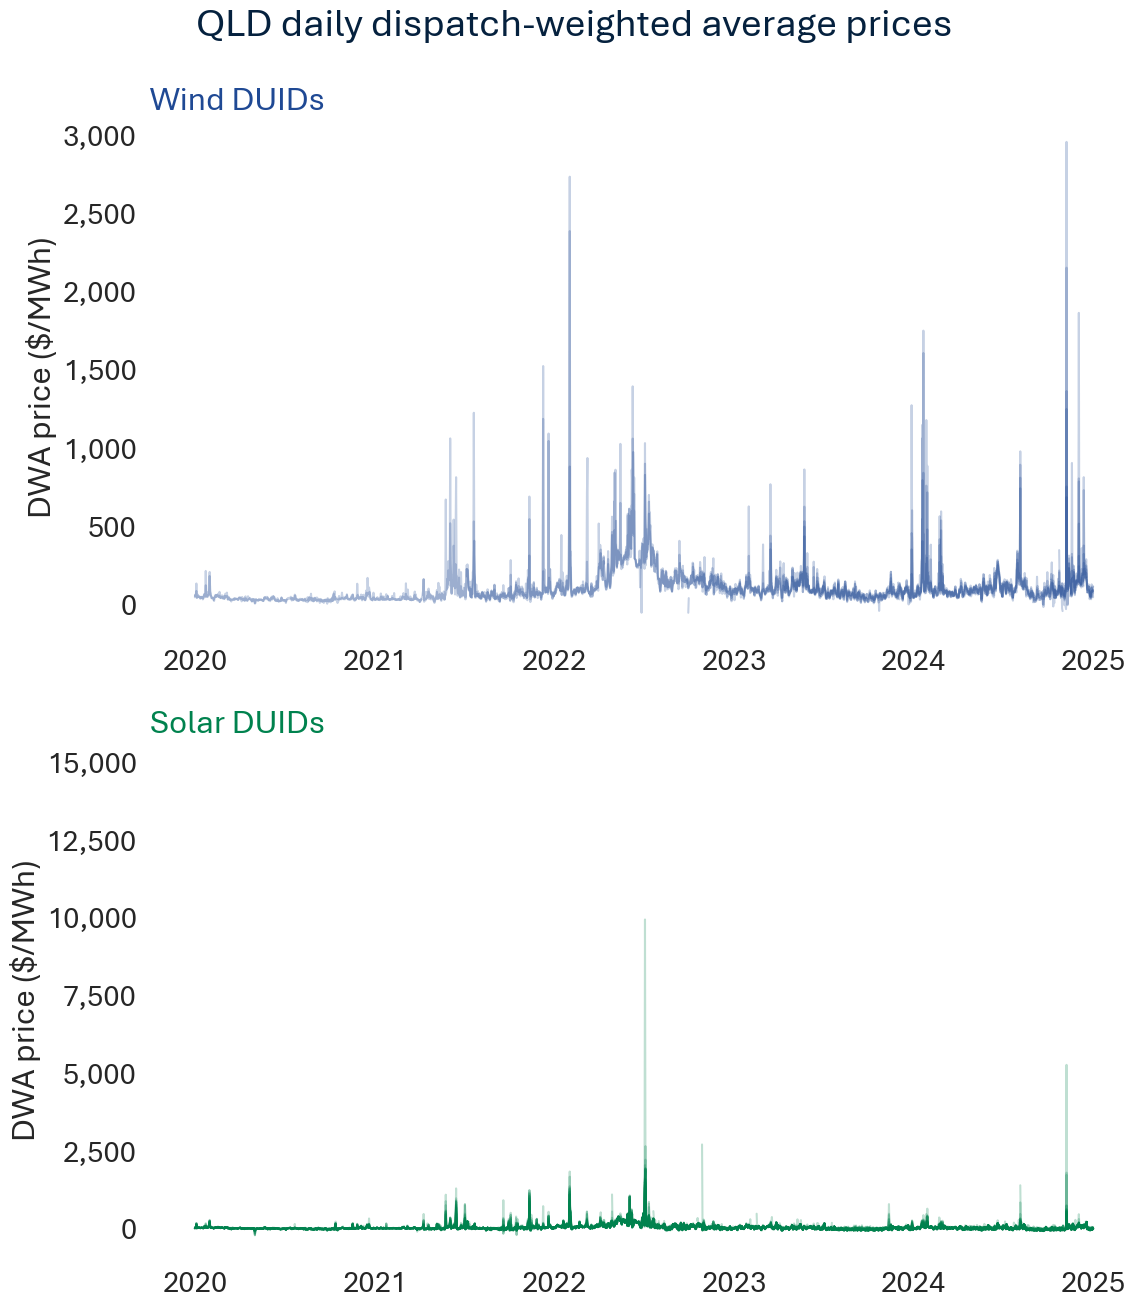

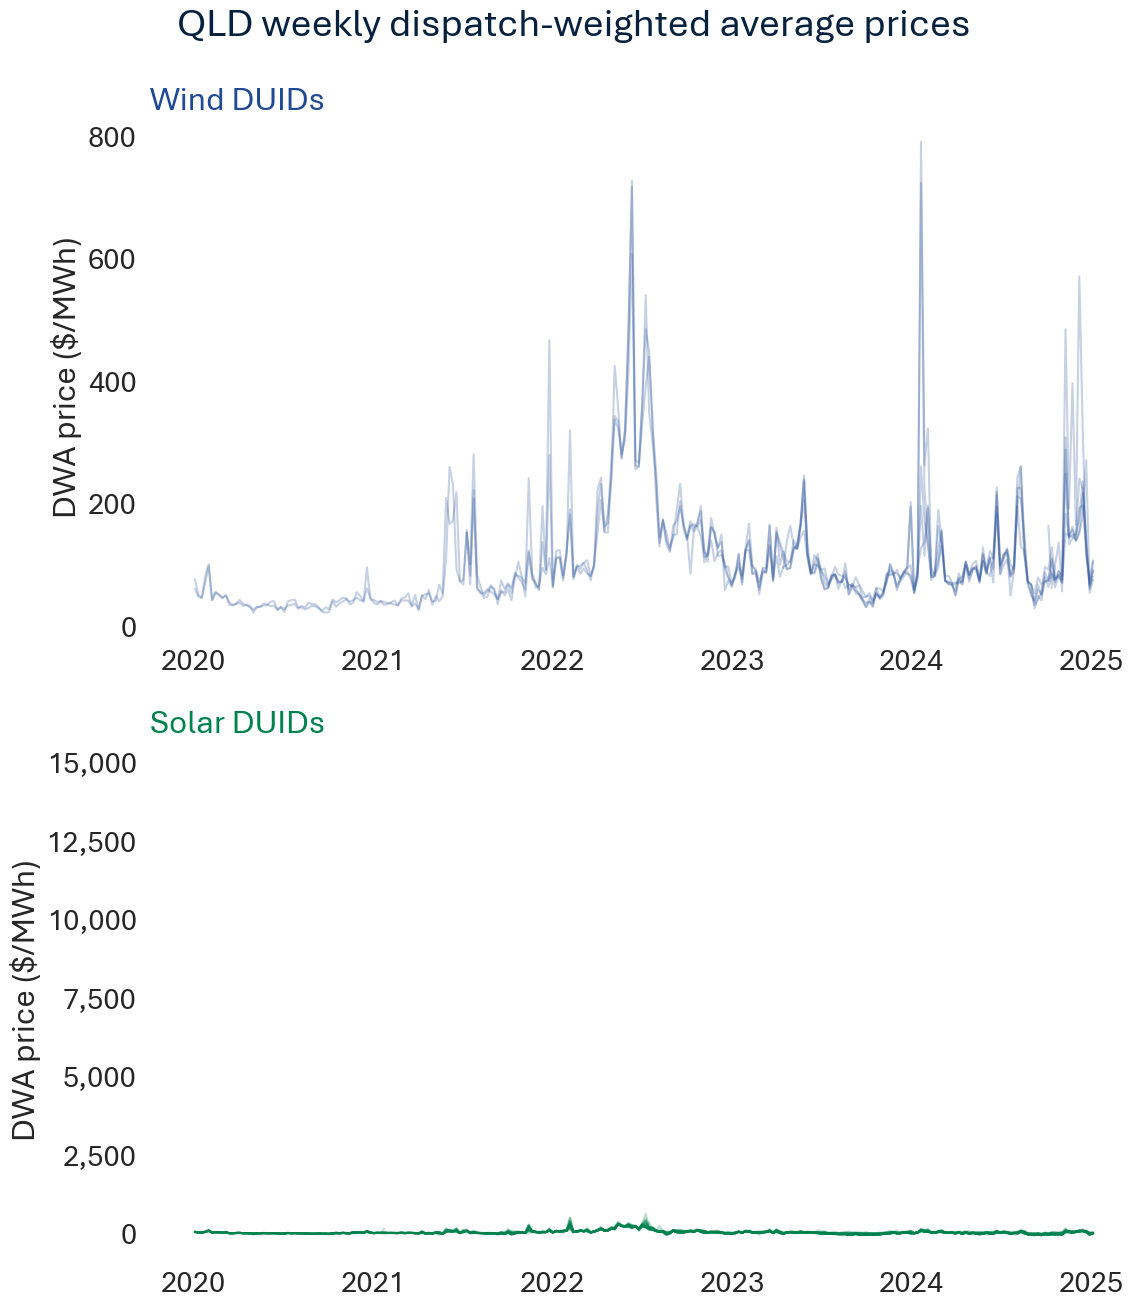

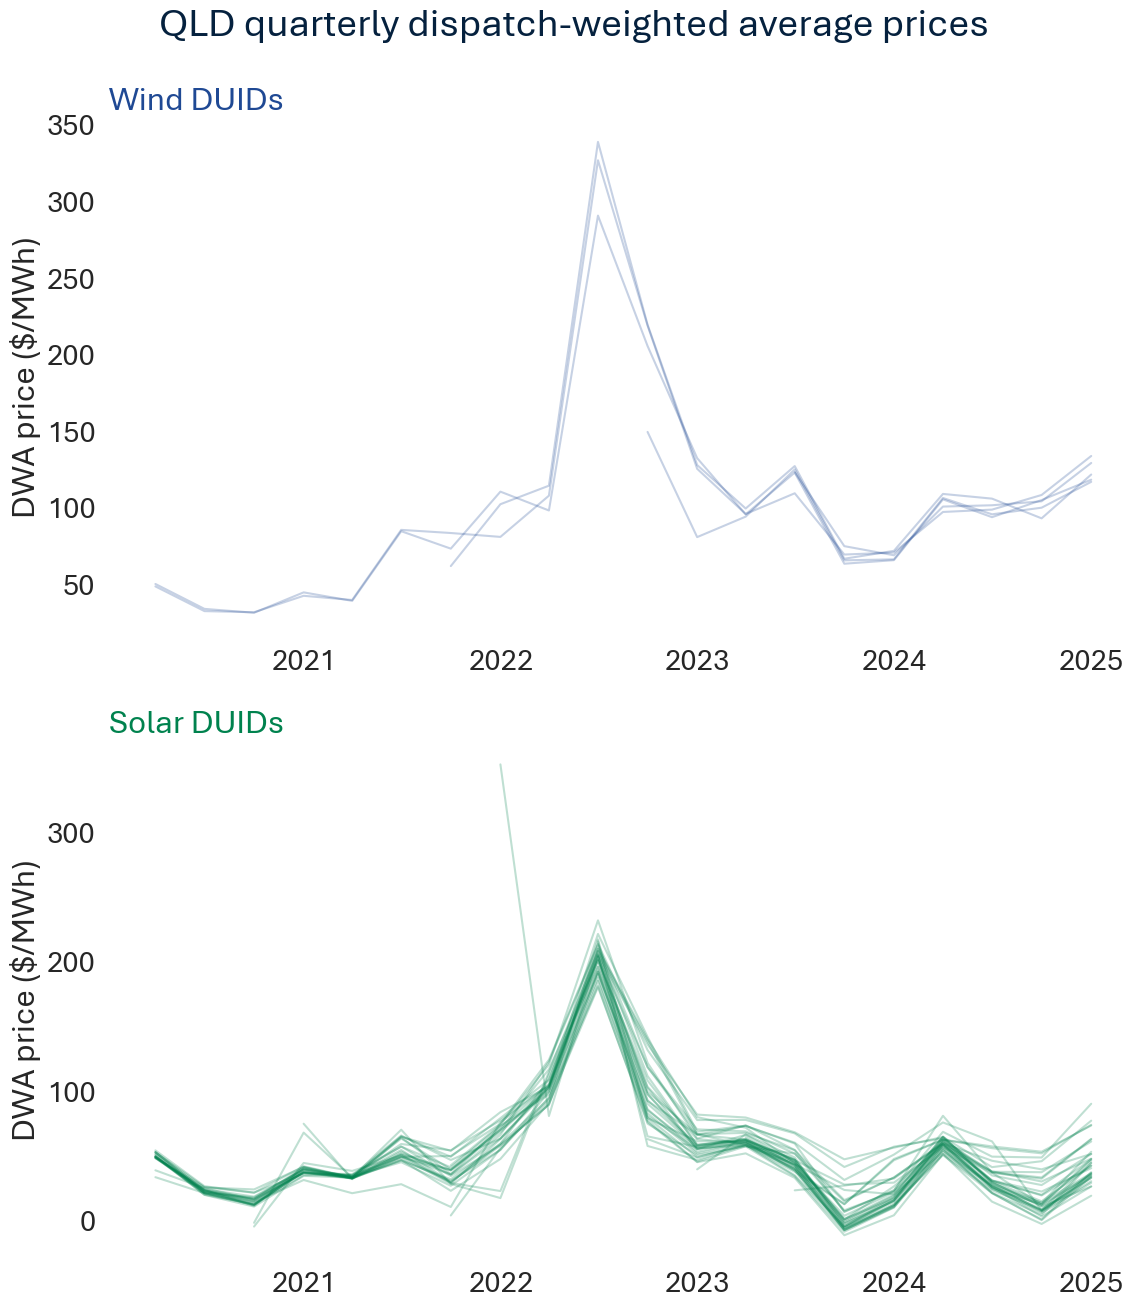

Preparing SA dispatch-weighted average prices ...


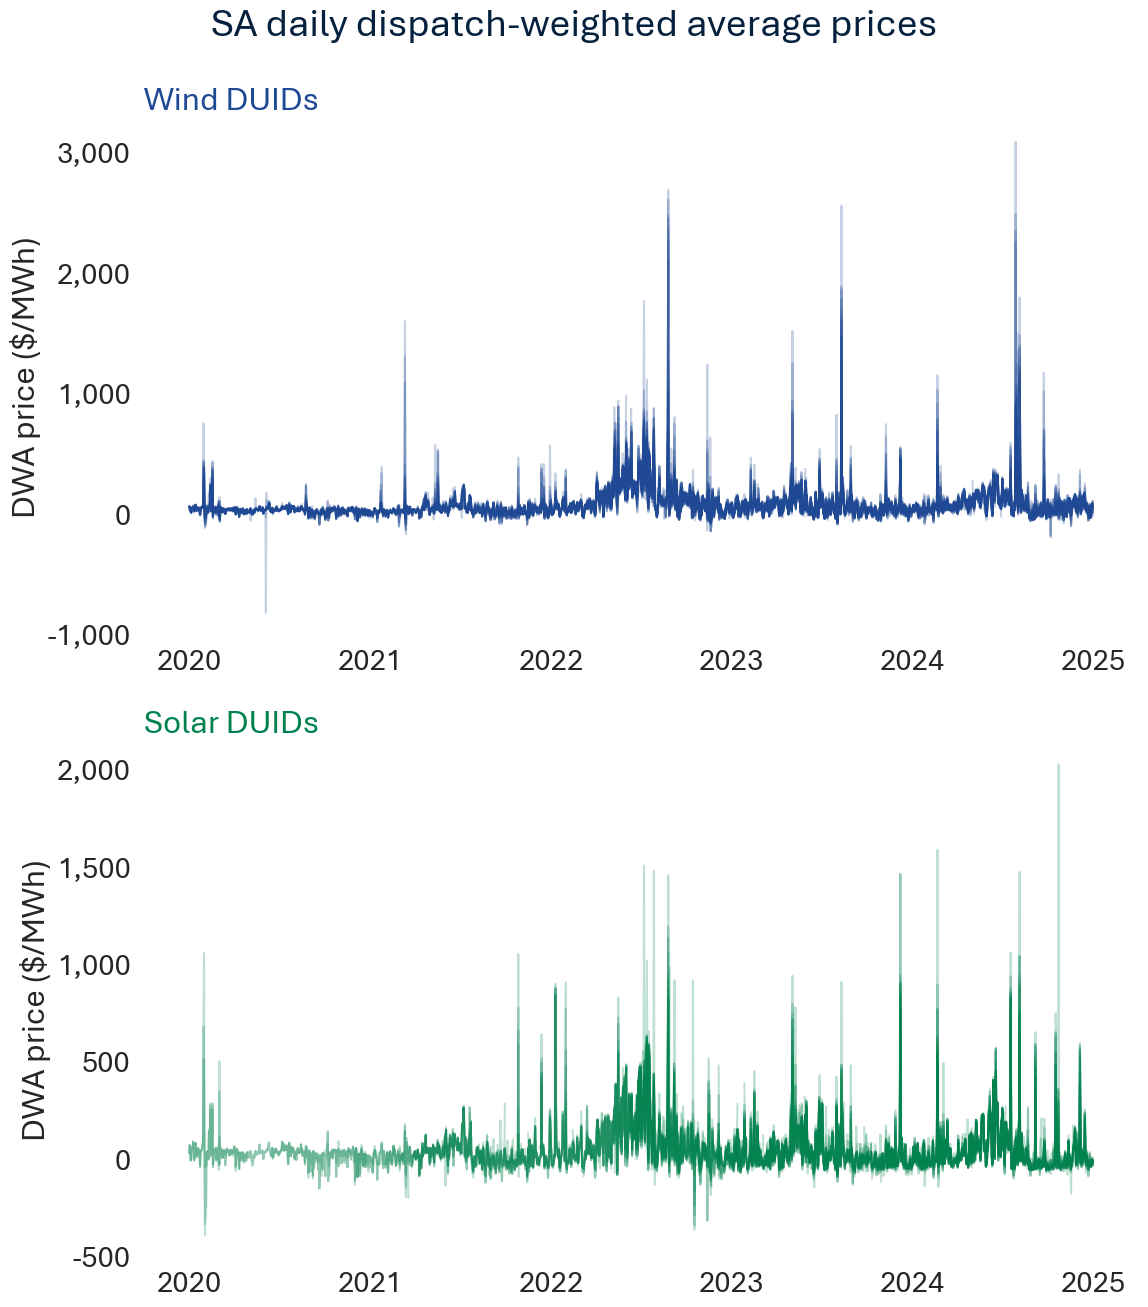

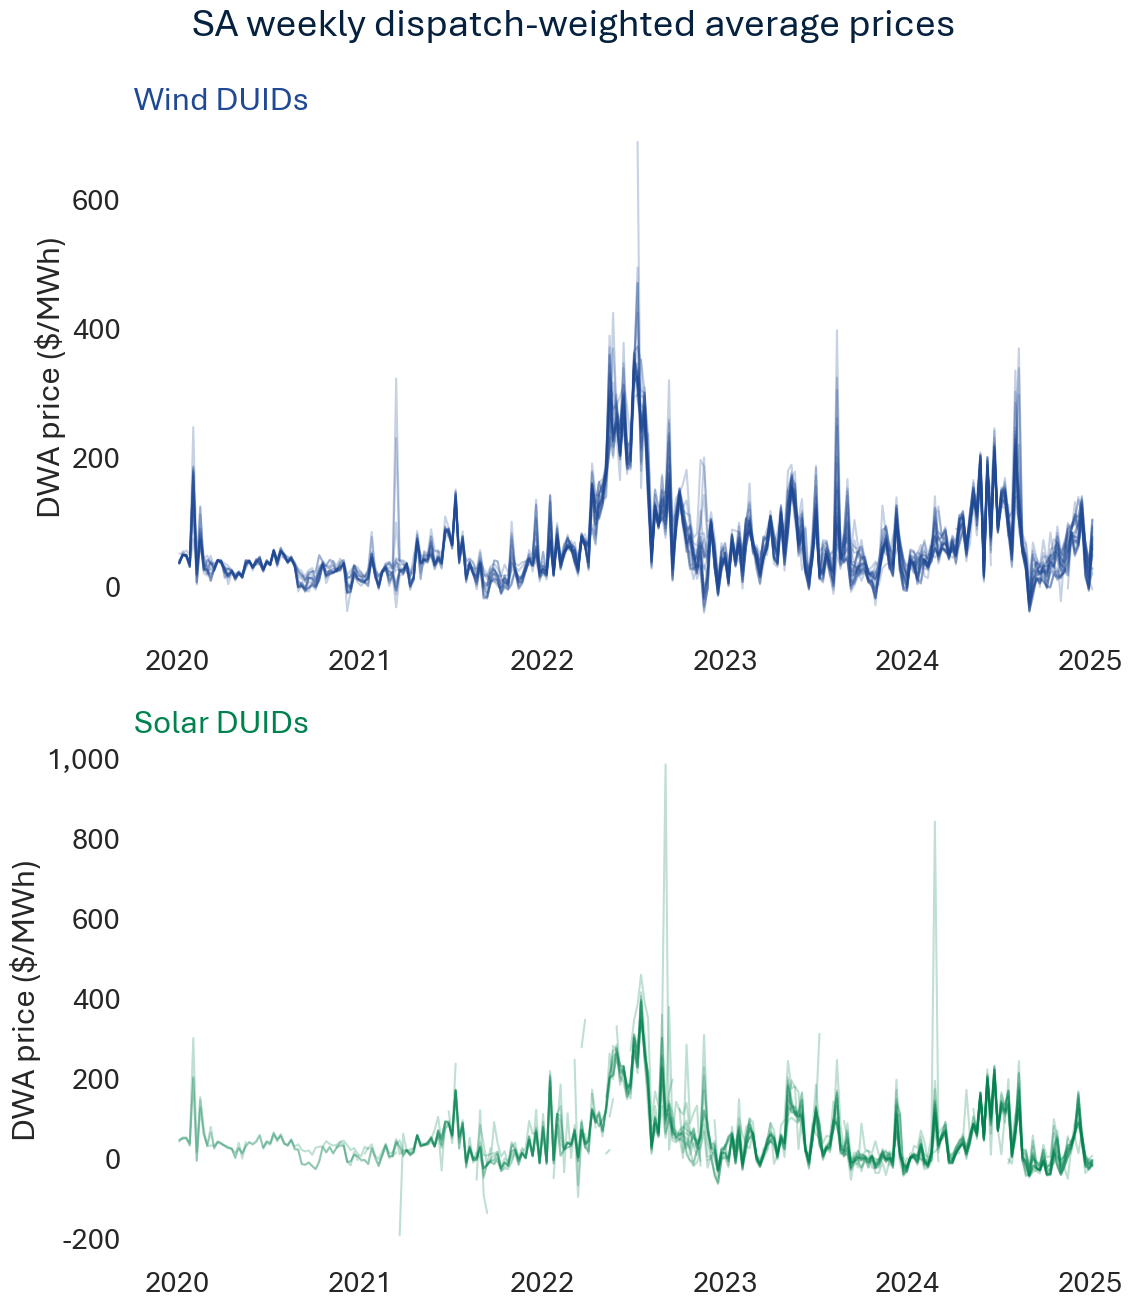

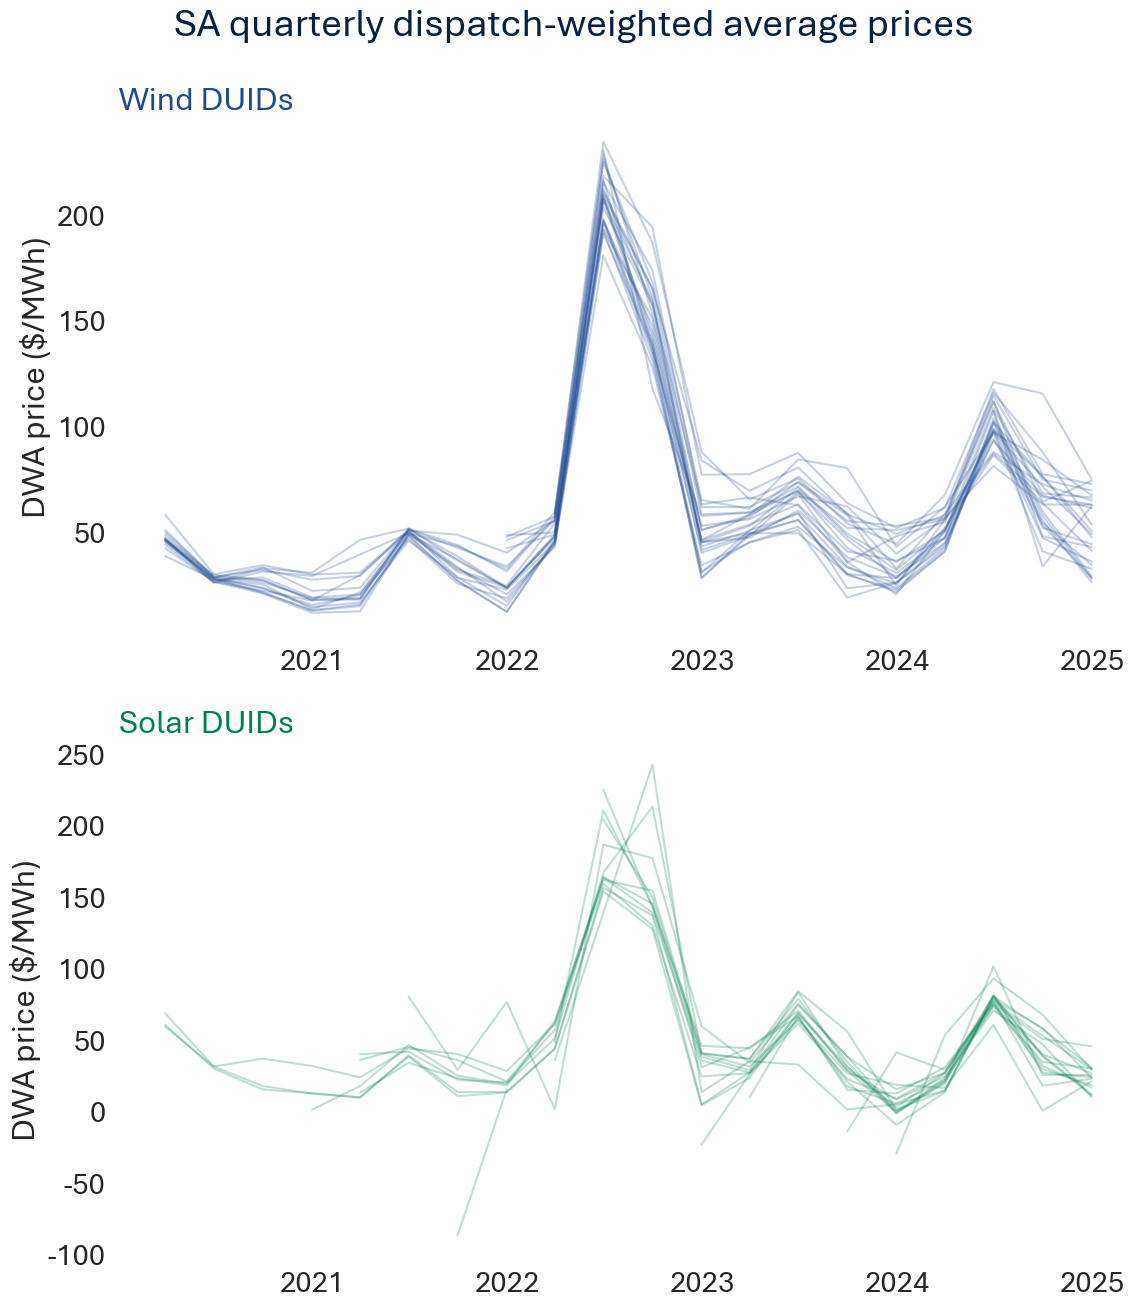

Preparing VIC dispatch-weighted average prices ...


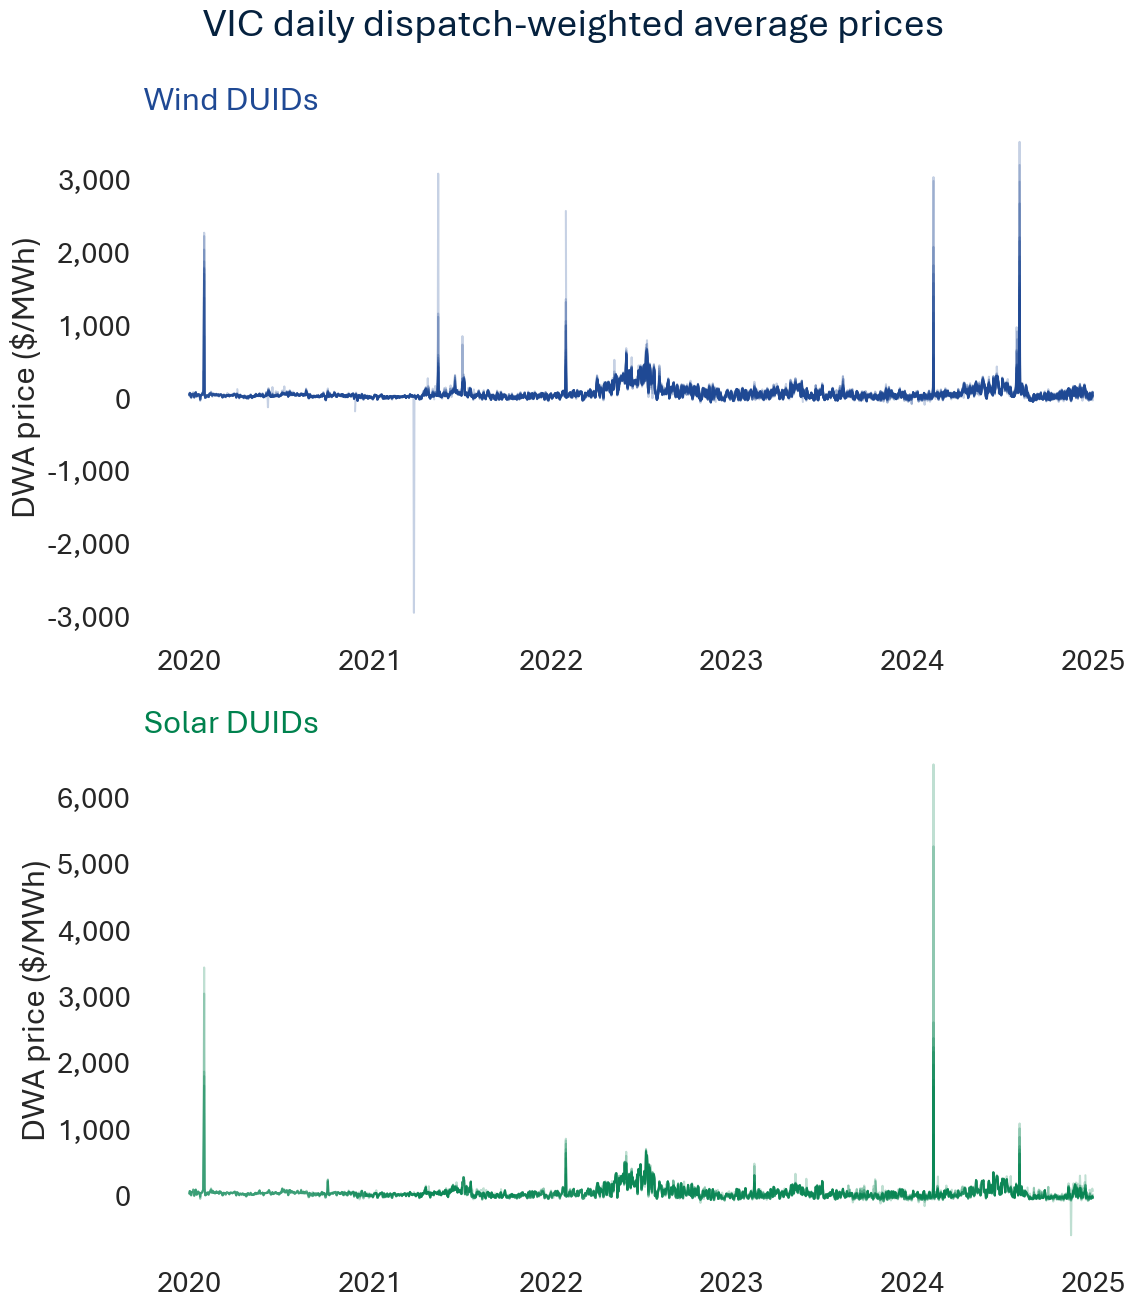

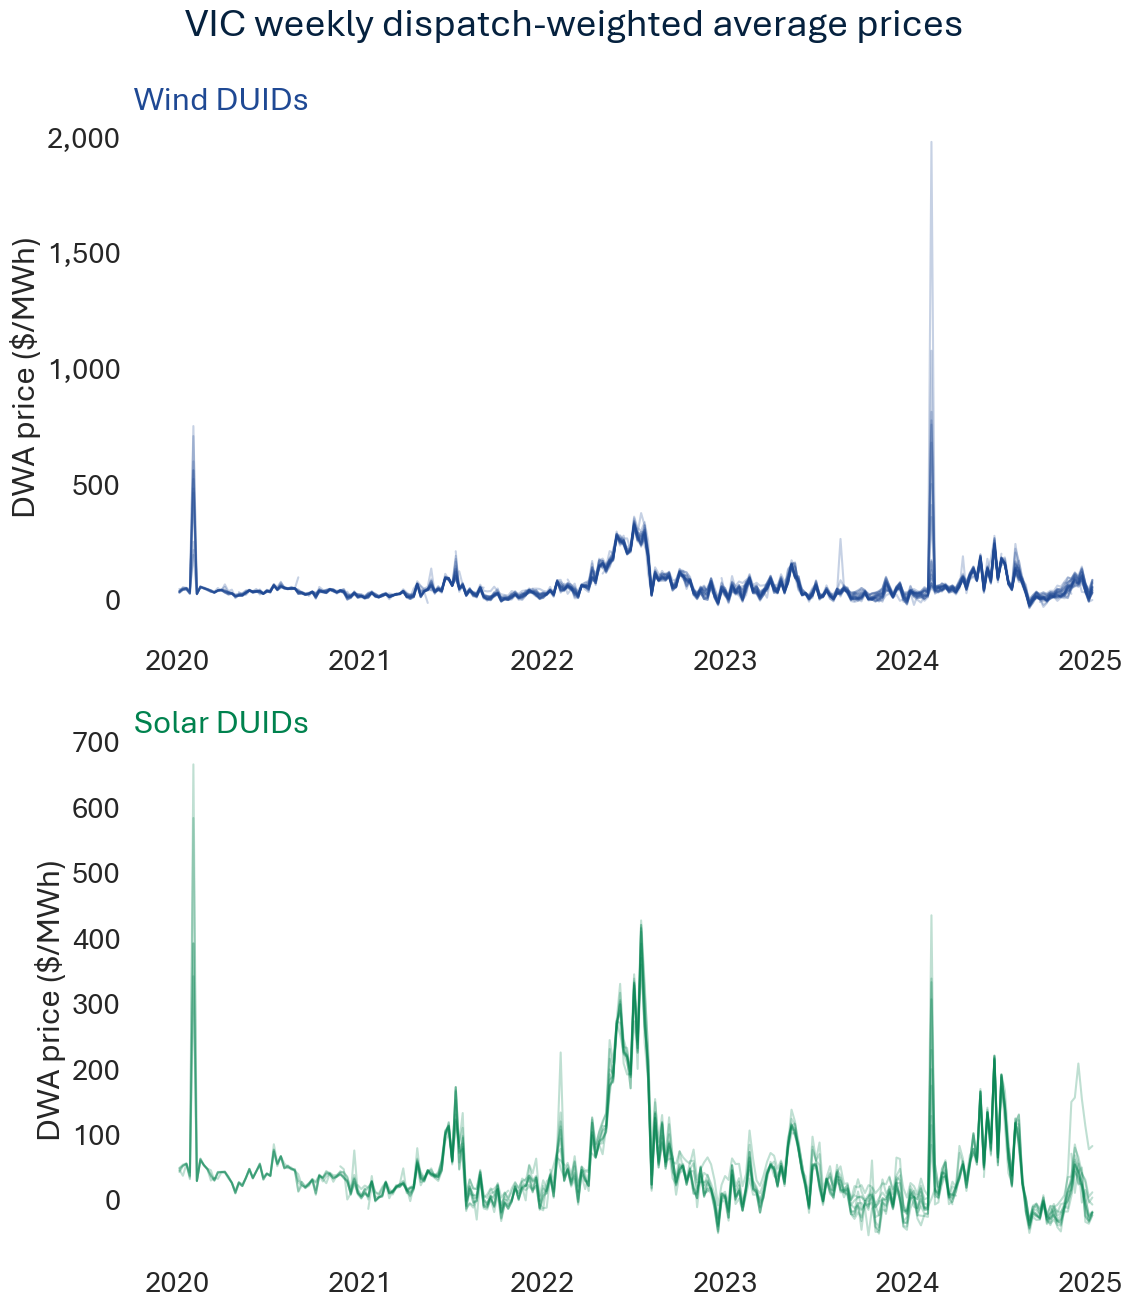

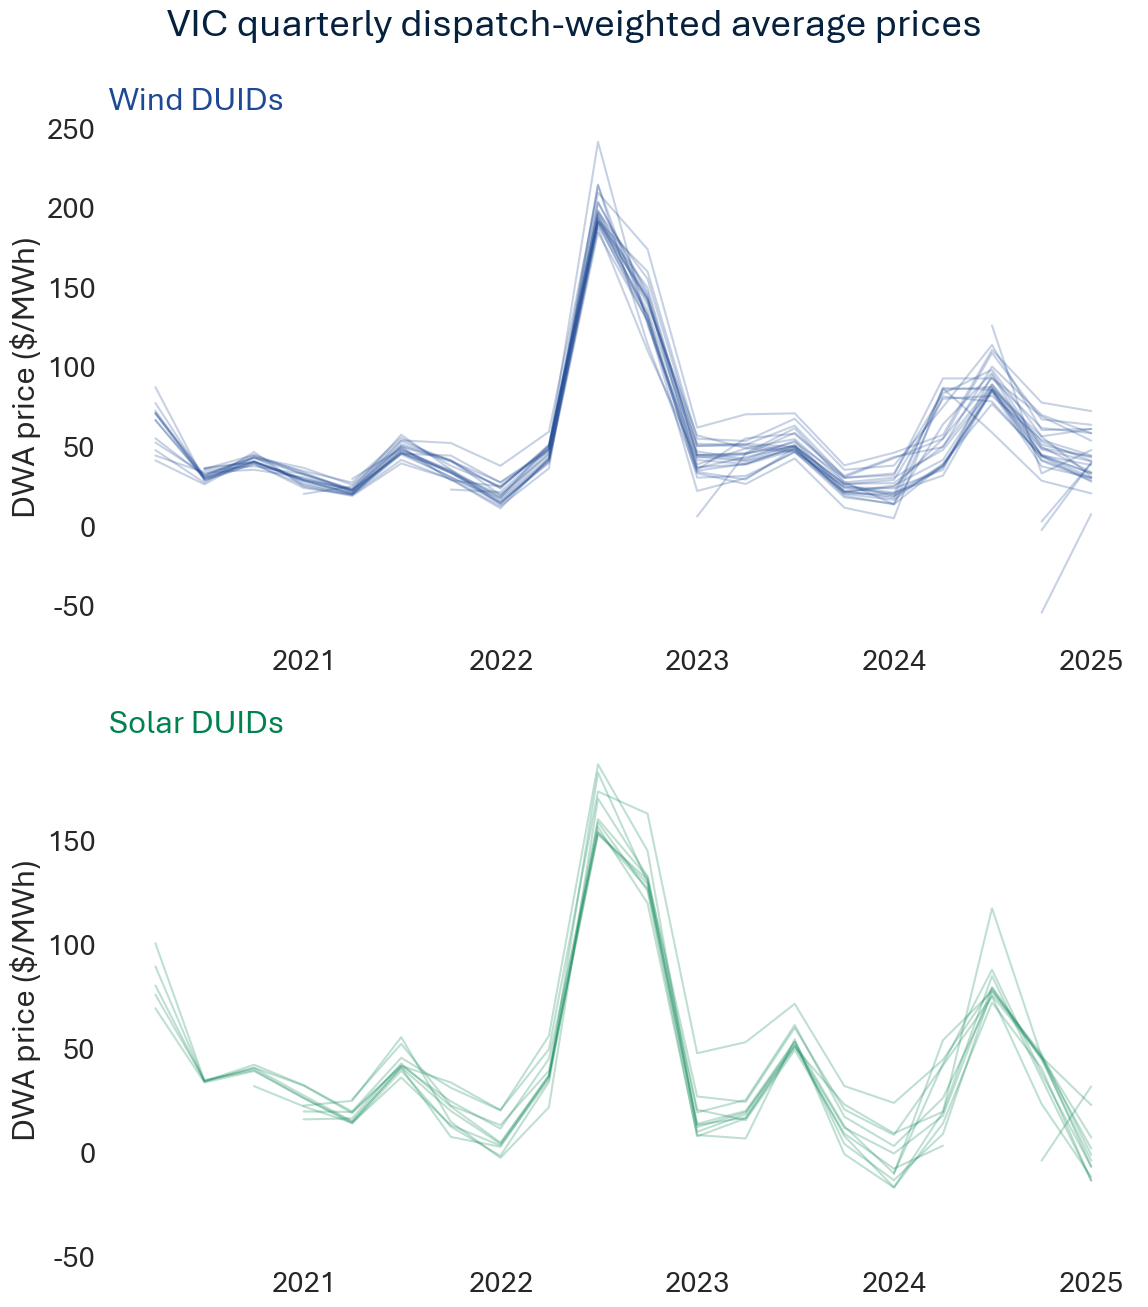

In [4]:
# Prepare DWA prices
for i, region in enumerate(regions):
    print(f"Preparing {region} dispatch-weighted average prices ...")
    # Prepare DUID data
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["DUID", "Interval", "Output"])
    # Attach 'technology' to DUID data
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values
    # Prepare market data
    region_market_data = pd.read_parquet(
        market_data_path,
        engine="pyarrow",
        filters=[("Region", "==", region)],
        columns=["Interval", "Price"]).set_index("Interval")
    # Merge price and generation data
    region_duid_data["Price"] = region_market_data.loc[region_duid_data["Interval"], "Price"].values
    region_duid_data["Revenue"] = region_duid_data["Output"] * region_duid_data["Price"]    
    region_dwa_prices = region_duid_data.pivot_table(
        index="Interval",
        columns=["Technology", "DUID"],
        values=["Revenue", "Output"])
    # Quarterly DWA prices
    region_dwa_prices_qtr = region_dwa_prices.resample("QE")["Revenue"].sum() / region_dwa_prices.resample("QE")["Output"].sum()
    region_dwa_prices_qtr.index.name = "Quarter"
    region_dwa_prices_qtr.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_quarterly.csv"))
    # Weekly DWA prices
    region_dwa_prices_wk = region_dwa_prices.resample("W")["Revenue"].sum() / region_dwa_prices.resample("W")["Output"].sum()
    region_dwa_prices_wk.index.name = "Week"
    region_dwa_prices_wk.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_weekly.csv"))
    # Daily DWA prices
    region_dwa_prices_daily = region_dwa_prices.resample("D")["Revenue"].sum() / region_dwa_prices.resample("D")["Output"].sum()
    region_dwa_prices_daily.index.name = "Date"
    region_dwa_prices_daily.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_daily.csv"))

    fig, ax = plt.subplots(
        2, 1,
        figsize=(12, 6.75 * 2),
        tight_layout=True)
    for i, tech in enumerate(["Wind", "Solar"]):
        axis = ax[i]
        chart_data = region_dwa_prices_daily[tech]
        for duid in chart_data.columns:
            axis.plot(
                chart_data.index,
                chart_data[duid],
                color=f"C{i + 1}",
                alpha=0.25)
        for frame in ["top", "right", "bottom", "left"]:
            axis.spines[frame].set_visible(False)
        axis.set_title(f"{tech} DUIDs", loc="left", color=f"C{i + 1}")
        axis.set_xlabel(None)
        axis.set_ylabel("DWA price ($/MWh)")
        axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    plt.suptitle(f"{region} daily dispatch-weighted average prices", fontweight="bold", color="C0")
    plt.show()
    save_figure(fig, f"{region}_dwa_duid_prices_daily", charts_dir)

    fig, ax = plt.subplots(
        2, 1,
        figsize=(12, 6.75 * 2),
        tight_layout=True)
    for i, tech in enumerate(["Wind", "Solar"]):
        axis = ax[i]
        chart_data = region_dwa_prices_wk[tech]
        for duid in chart_data.columns:
            axis.plot(
                chart_data.index,
                chart_data[duid],
                color=f"C{i + 1}",
                alpha=0.25)
        for frame in ["top", "right", "bottom", "left"]:
            axis.spines[frame].set_visible(False)
        axis.set_title(f"{tech} DUIDs", loc="left", color=f"C{i + 1}")
        axis.set_xlabel(None)
        axis.set_ylabel("DWA price ($/MWh)")
        axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    plt.suptitle(f"{region} weekly dispatch-weighted average prices", fontweight="bold", color="C0")
    plt.show()
    save_figure(fig, f"{region}_dwa_duid_prices_weekly", charts_dir)

    fig, ax = plt.subplots(
        2, 1,
        figsize=(12, 6.75 * 2),
        tight_layout=True)
    for i, tech in enumerate(["Wind", "Solar"]):
        axis = ax[i]
        chart_data = region_dwa_prices_qtr[tech]
        for duid in chart_data.columns:
            axis.plot(
                chart_data.index,
                chart_data[duid],
                color=f"C{i + 1}",
                alpha=0.25)
        for frame in ["top", "right", "bottom", "left"]:
            axis.spines[frame].set_visible(False)
        axis.set_title(f"{tech} DUIDs", loc="left", color=f"C{i + 1}")
        axis.set_xlabel(None)
        axis.set_ylabel("DWA price ($/MWh)")
        axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    plt.suptitle(f"{region} quarterly dispatch-weighted average prices", fontweight="bold", color="C0")
    plt.show()
    save_figure(fig, f"{region}_dwa_duid_prices_quarterly", charts_dir)

NSW


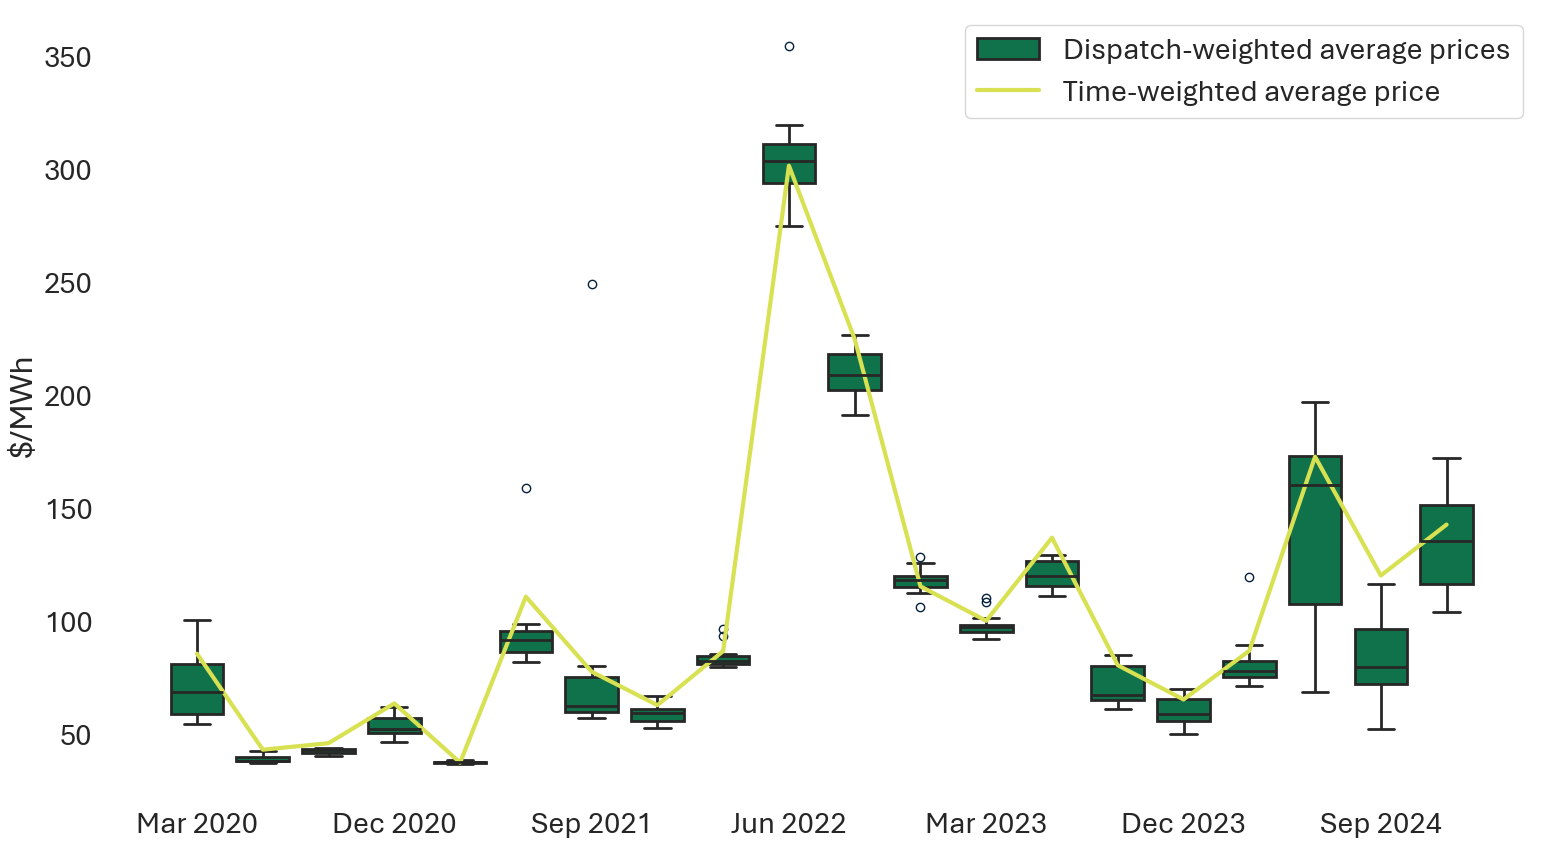

QLD


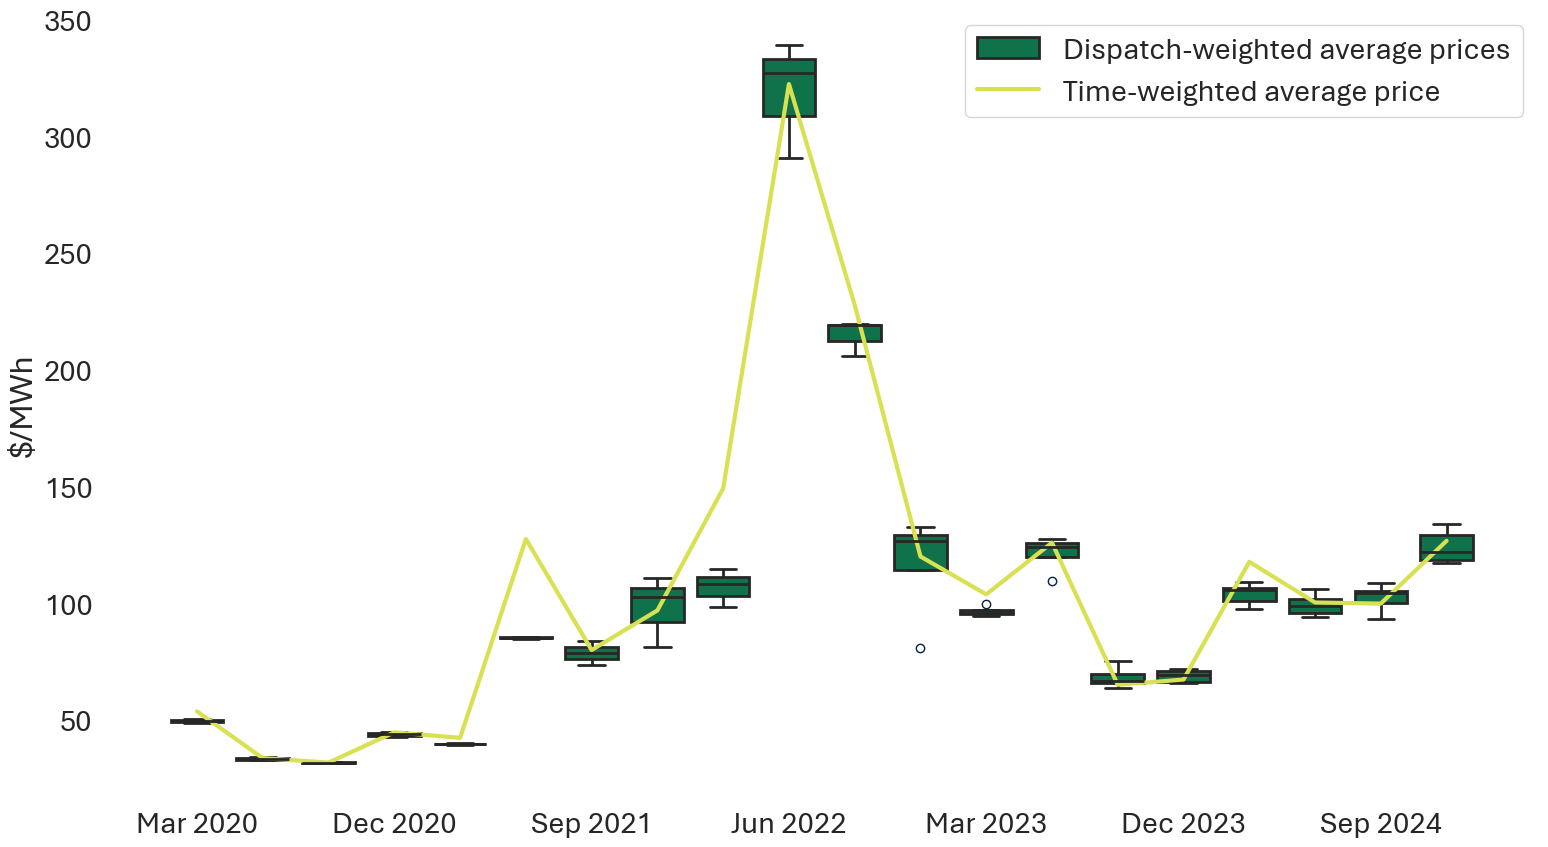

SA


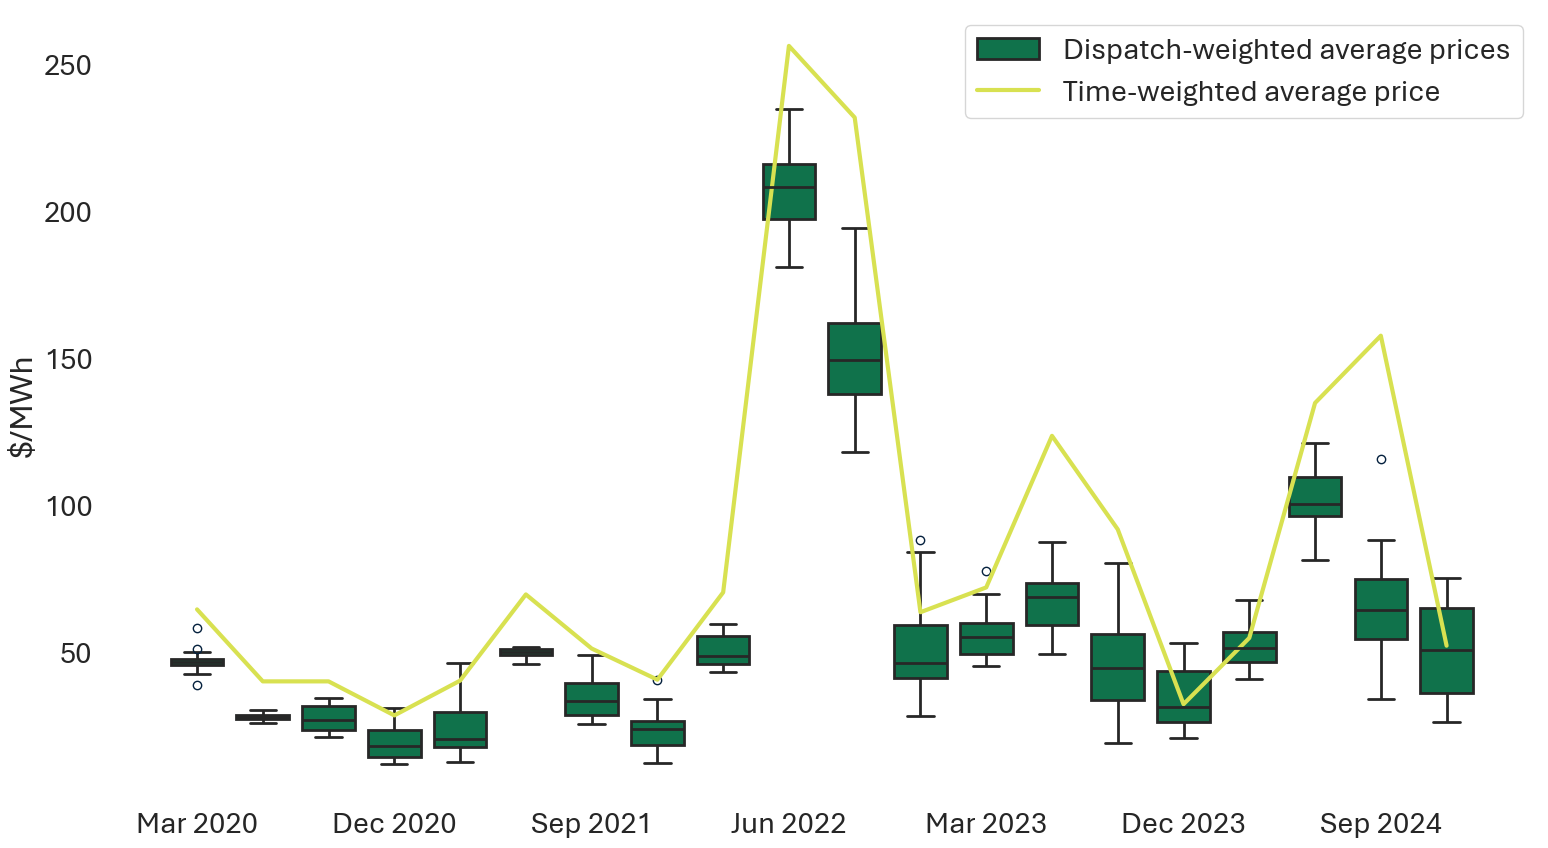

VIC


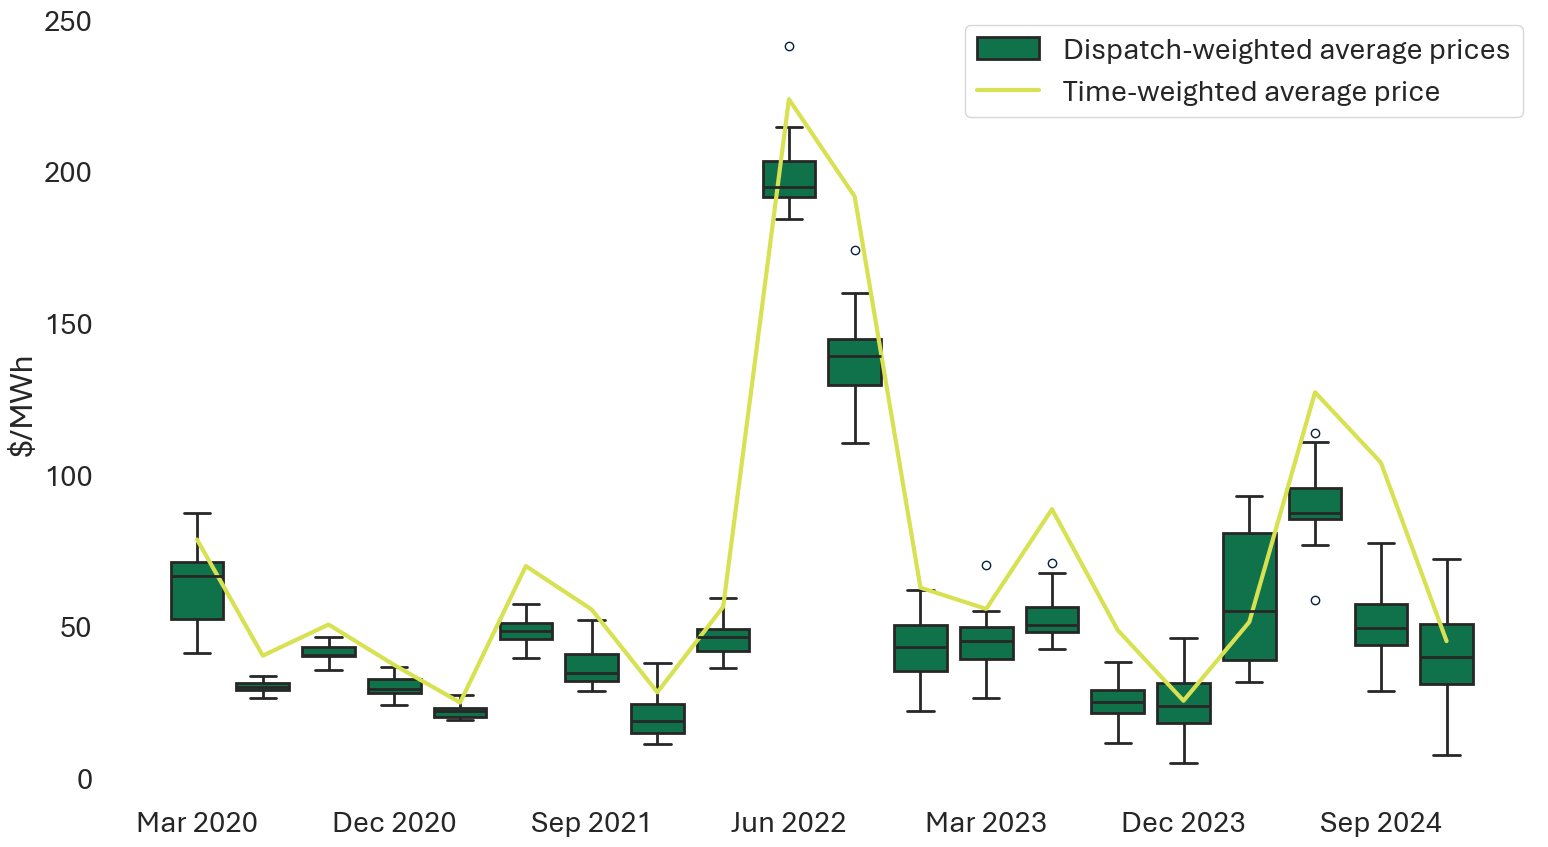

In [52]:
for i, region in enumerate(regions):
    print(region)
    # Load and prepare DWA data
    region_dwas = pd.read_csv(
        os.path.join(data_dir, f"{region}_duid_dwa_prices_quarterly.csv"),
        header=[0, 1],
        parse_dates=[0],
        index_col=0)["Wind"]
    quarters = region_dwas.index

    # Filter out invalid sequences
    first_row = region_dwas.iloc[0]
    region_dwas_valid = region_dwas.shift(1).notna()
    region_dwas = region_dwas.where(region_dwas_valid)
    region_dwas.iloc[0] = first_row

    # Melt for boxplot
    box_data = region_dwas.reset_index().melt(
        id_vars="Quarter",
        var_name="DUID",
        value_name="DWA price")

    # Load and prepare TWA data
    twa_data = pd.read_parquet(
        market_data_path,
        filters=[("Region", "==", region)],
        columns=["Interval", "Price"]
    ).set_index("Interval")

    # Resample to quarterly
    twa_quarterly = twa_data.resample("QE").mean()
    twa_quarterly.index = range(len(twa_quarterly))

    # Create plot
    fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

    # Create boxplot
    sns.boxplot(
        ax=ax,
        data=box_data,
        x="Quarter",
        y="DWA price",
        color="C2",
        linewidth=2,
        flierprops=dict(markeredgecolor="C0"),
        label="Dispatch-weighted average prices")

    # Plot TWA line
    sns.lineplot(
        x=twa_quarterly.index,        
        y=twa_quarterly["Price"],
        color="C4",
        linewidth=3,
        ax=ax,
        label="Time-weighted average price")

    # Format x-axis
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])

    # Clean up
    for frame in ["top", "right", "bottom", "left"]:
        ax.spines[frame].set_visible(False)

    ax.set_ylabel("$/MWh")
    ax.set_xlabel(None)
    plt.show()
    save_figure(fig, f"{region}_dwa_twa_wind_quarterly_prices", charts_dir)

NSW


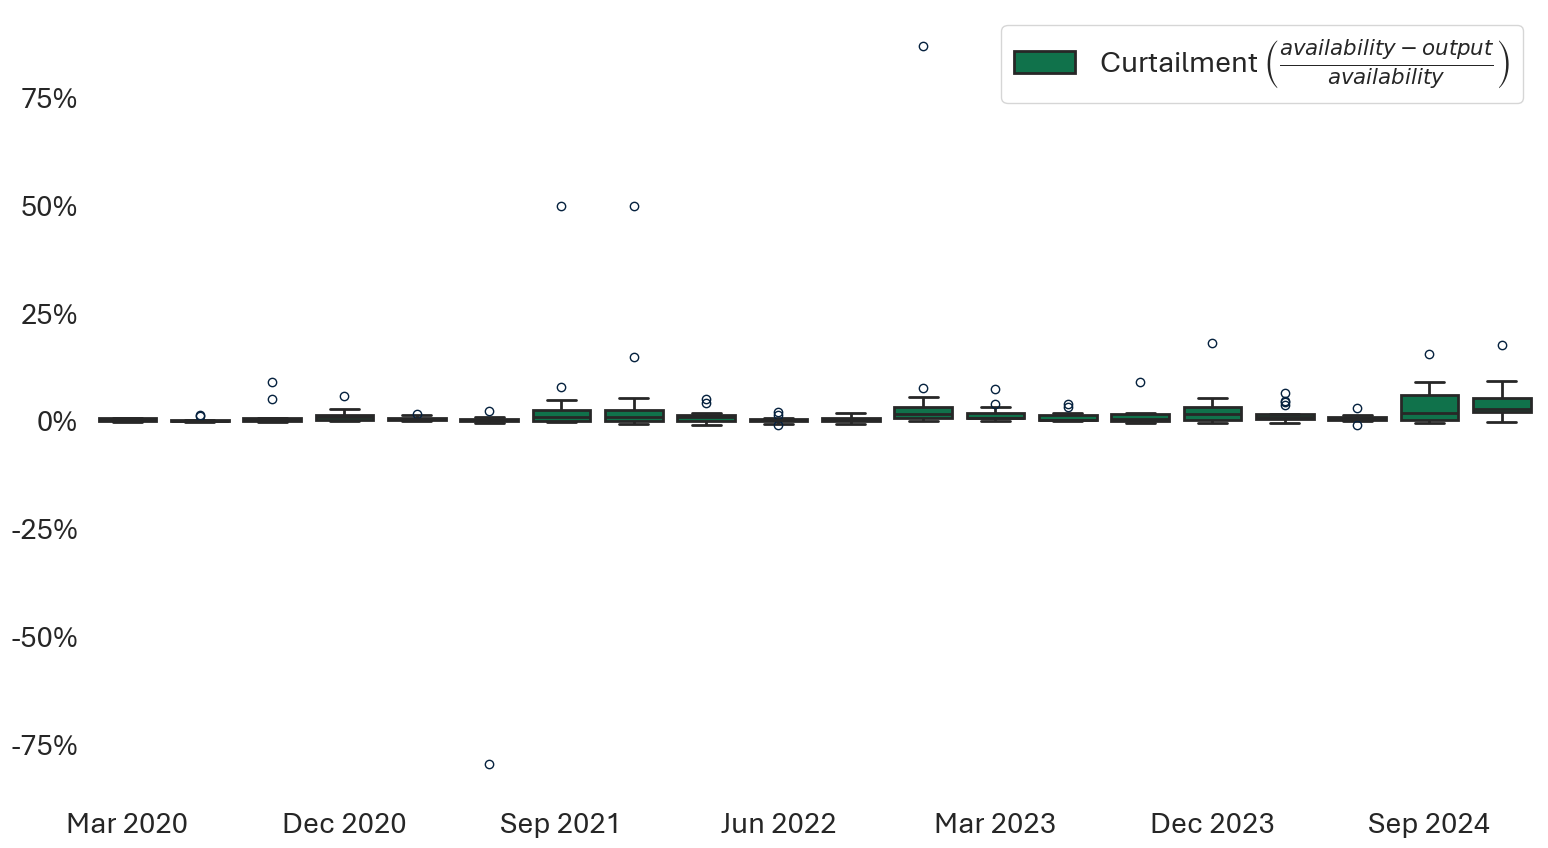

QLD


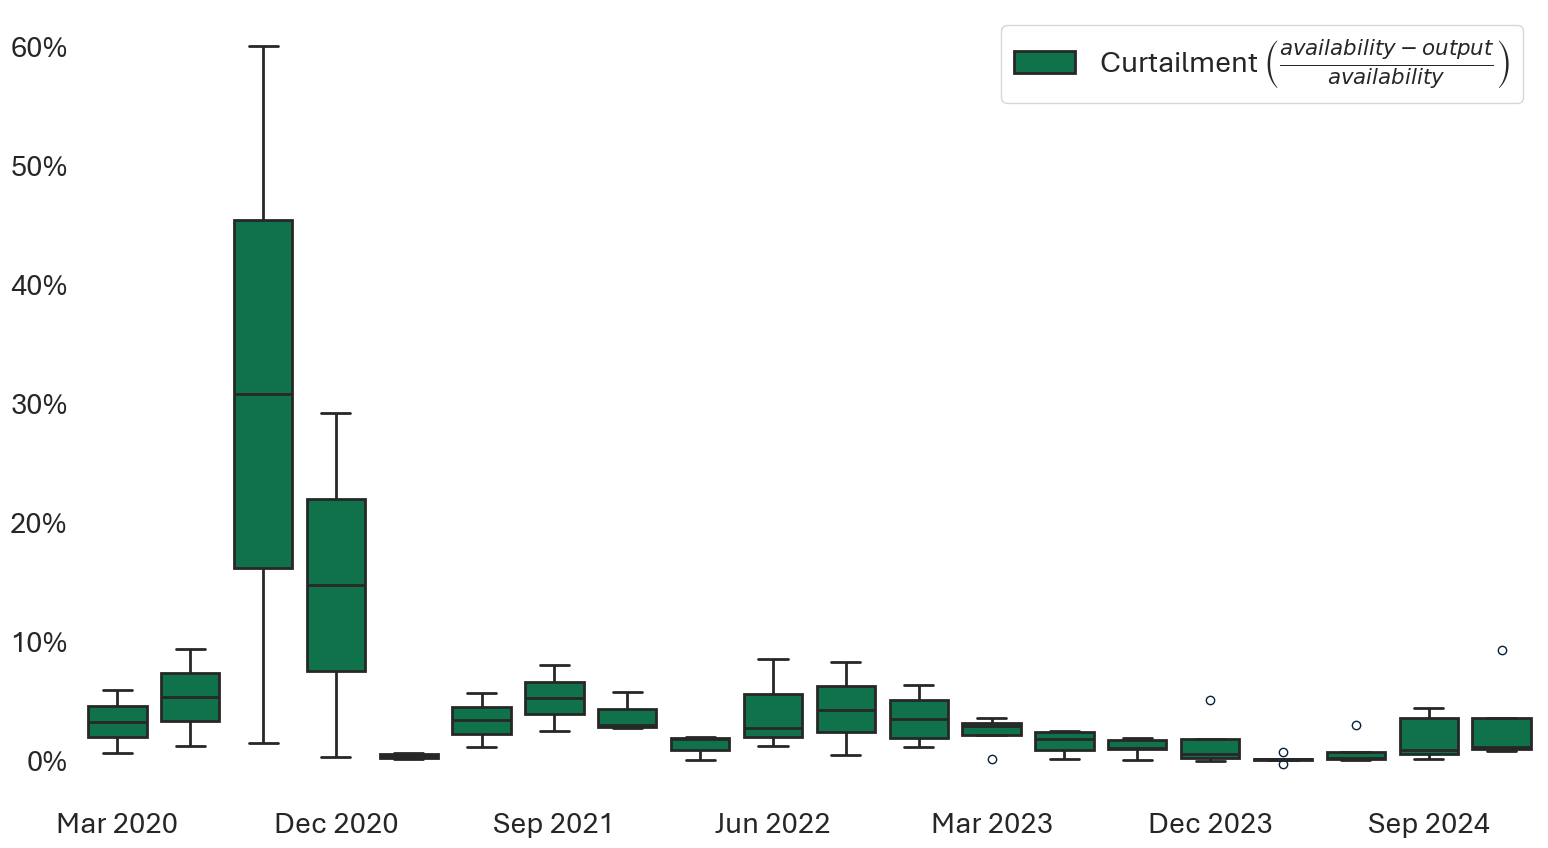

SA


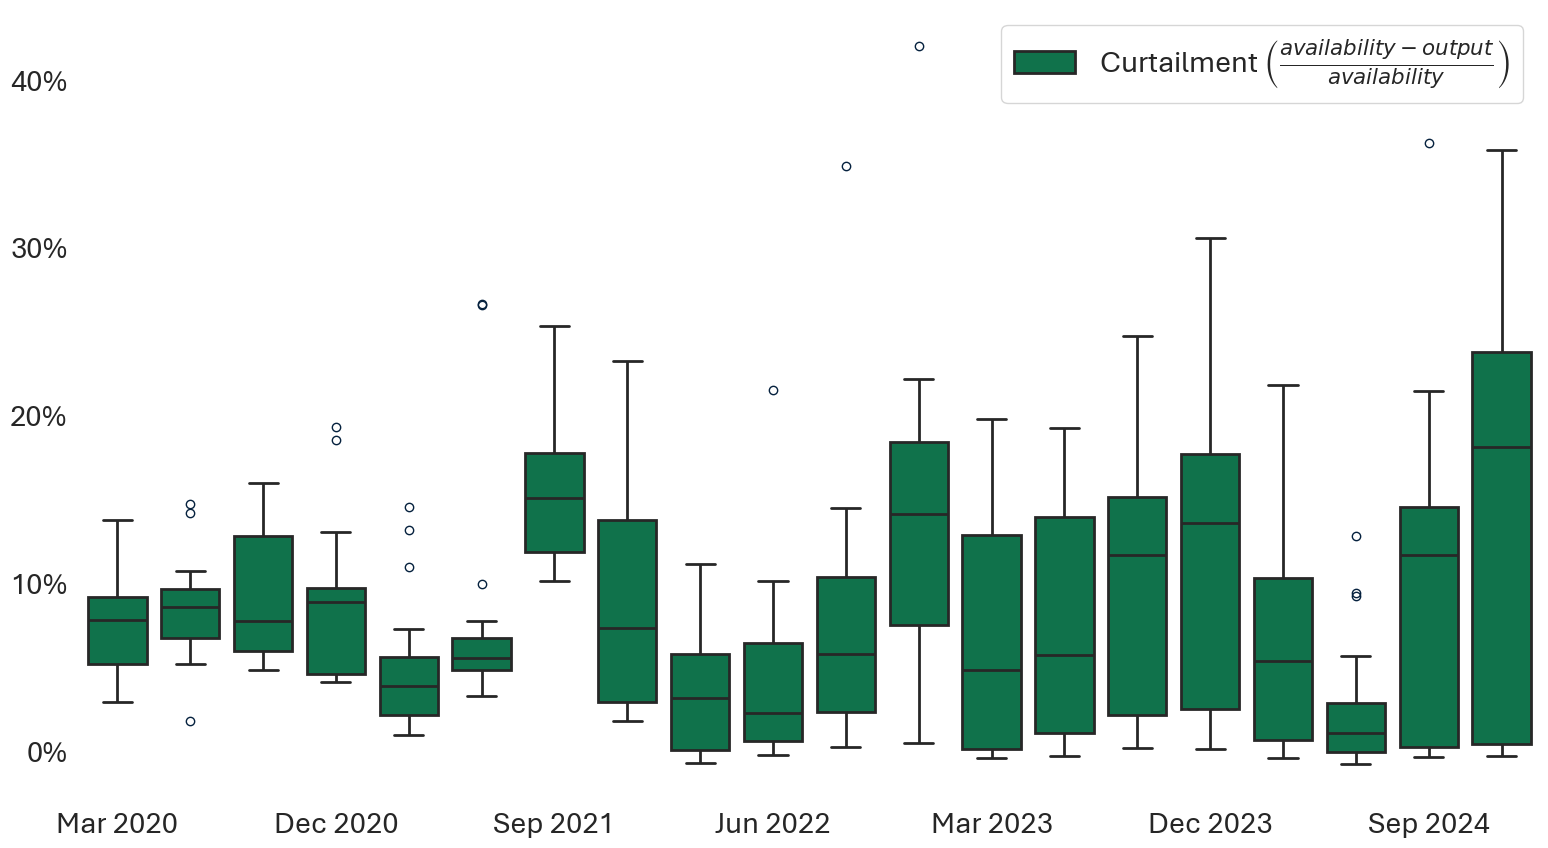

VIC


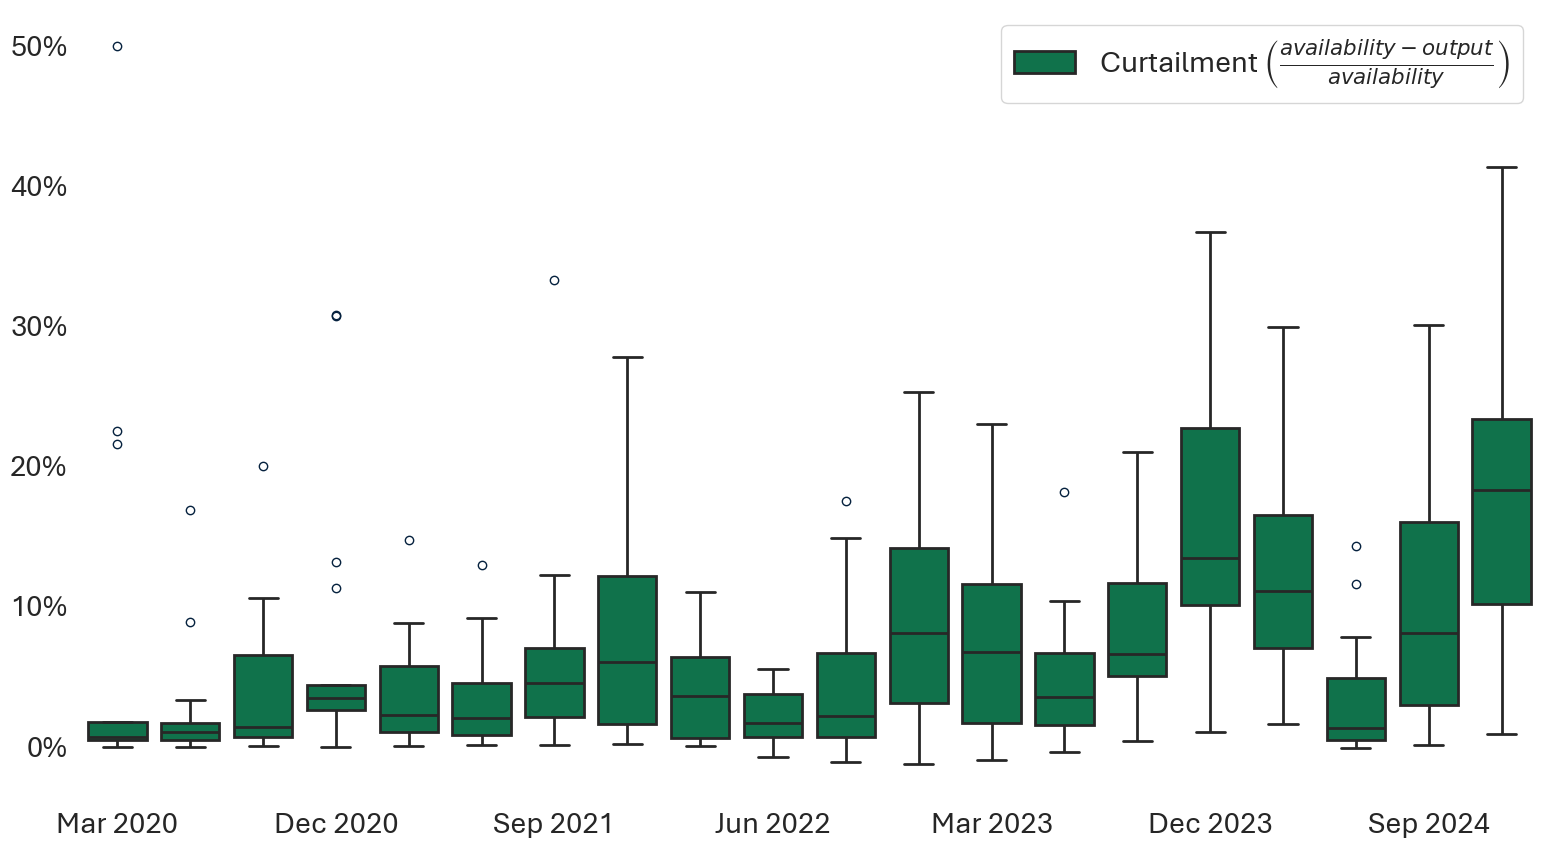

In [110]:
for i, region in enumerate(regions):
    print(region)

    # Load and prepare performancedata
    region_duids = gen_info[
        (gen_info["Technology"] == "Wind") &
        (gen_info["Region"] == region)].index    
    region_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["Interval", "Output", "Availability", "DUID"])
    region_data = region_data.pivot_table(
        index="Interval",
        columns="DUID",
        values=["Output", "Availability"],
        aggfunc="sum")
    region_data = region_data.resample("QE").sum()
    region_data.index.name = "Quarter"
    quarters = region_data.index
    region_performance = 1 - region_data["Output"] / region_data["Availability"]    
    
    # Filter out invalid sequences
    region_performance = region_performance.replace([np.inf, -np.inf], np.nan)
    region_performance_valid = region_data["Availability"].notna()
    del region_data
    first_row = region_performance.iloc[0]
    region_performance_valid = region_performance.shift(1).notna()
    region_performance = region_performance.where(region_performance_valid)
    region_performance.iloc[0] = first_row

    # Melt for boxplot
    box_data = region_performance.reset_index().melt(
        id_vars="Quarter",
        var_name="DUID",
        value_name="Curtailment")
    region_performance.to_csv(
        os.path.join(data_dir, f"{region}_duid_wind_curtailment_quarterly.csv"))

    # Create plot
    fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

    # Create boxplot
    sns.boxplot(
        ax=ax,
        data=box_data,
        x="Quarter",
        y="Curtailment",
        color="C2",
        linewidth=2,
        flierprops=dict(markeredgecolor="C0"),
        label=r"Curtailment $\left(\frac{availability - output}{availability}\right)$")

    # Format axes
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0%}")

    # Clean up
    for frame in ["top", "right", "bottom", "left"]:
        ax.spines[frame].set_visible(False)

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    plt.show()
    save_figure(fig, f"{region}_duid_wind_quarterly_curtailment", charts_dir)

NSW


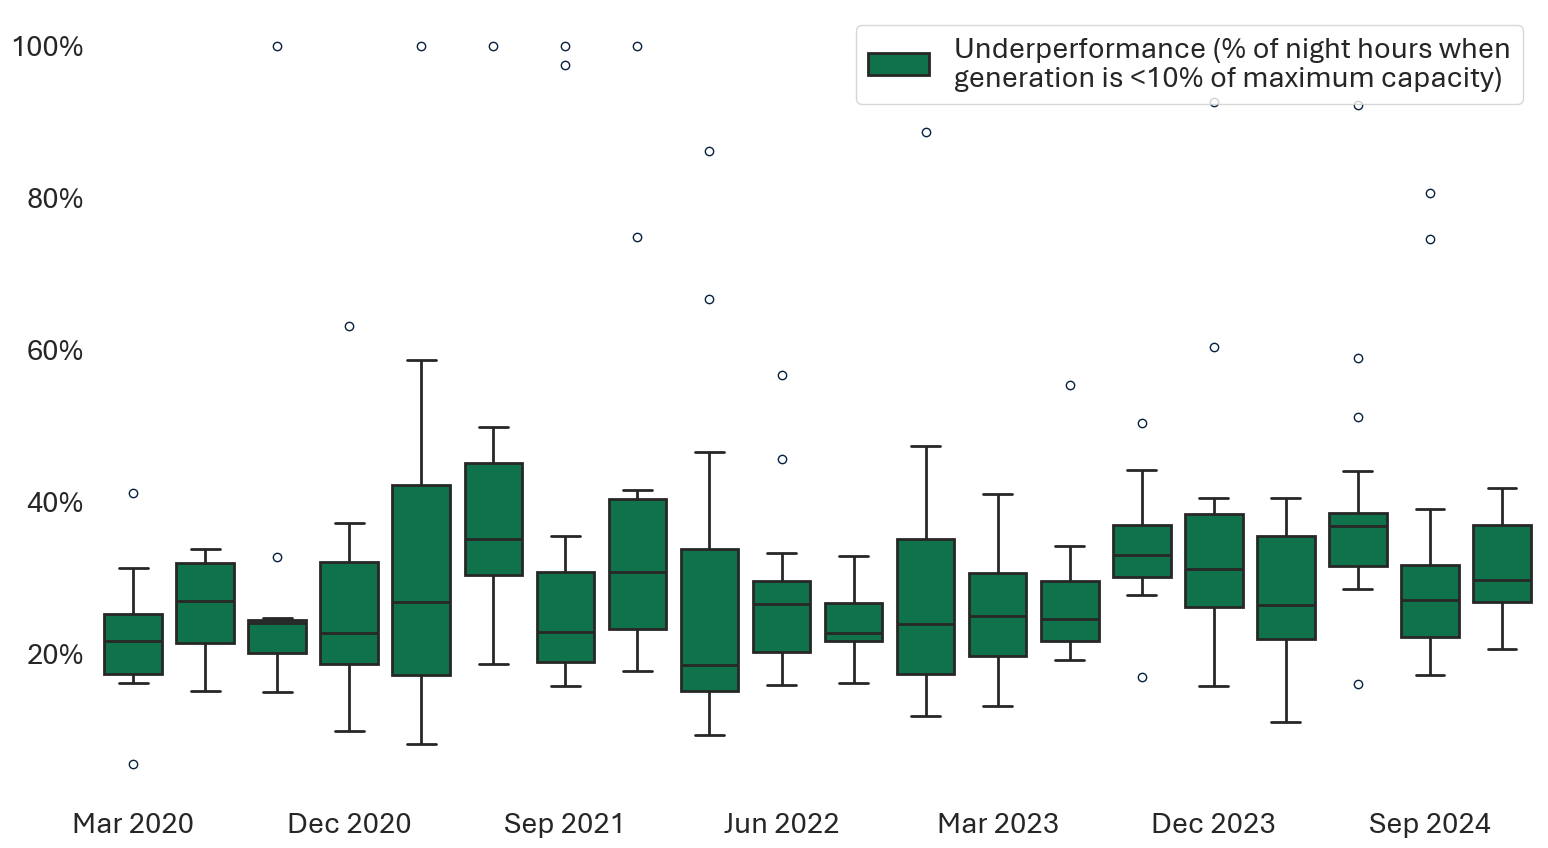

QLD


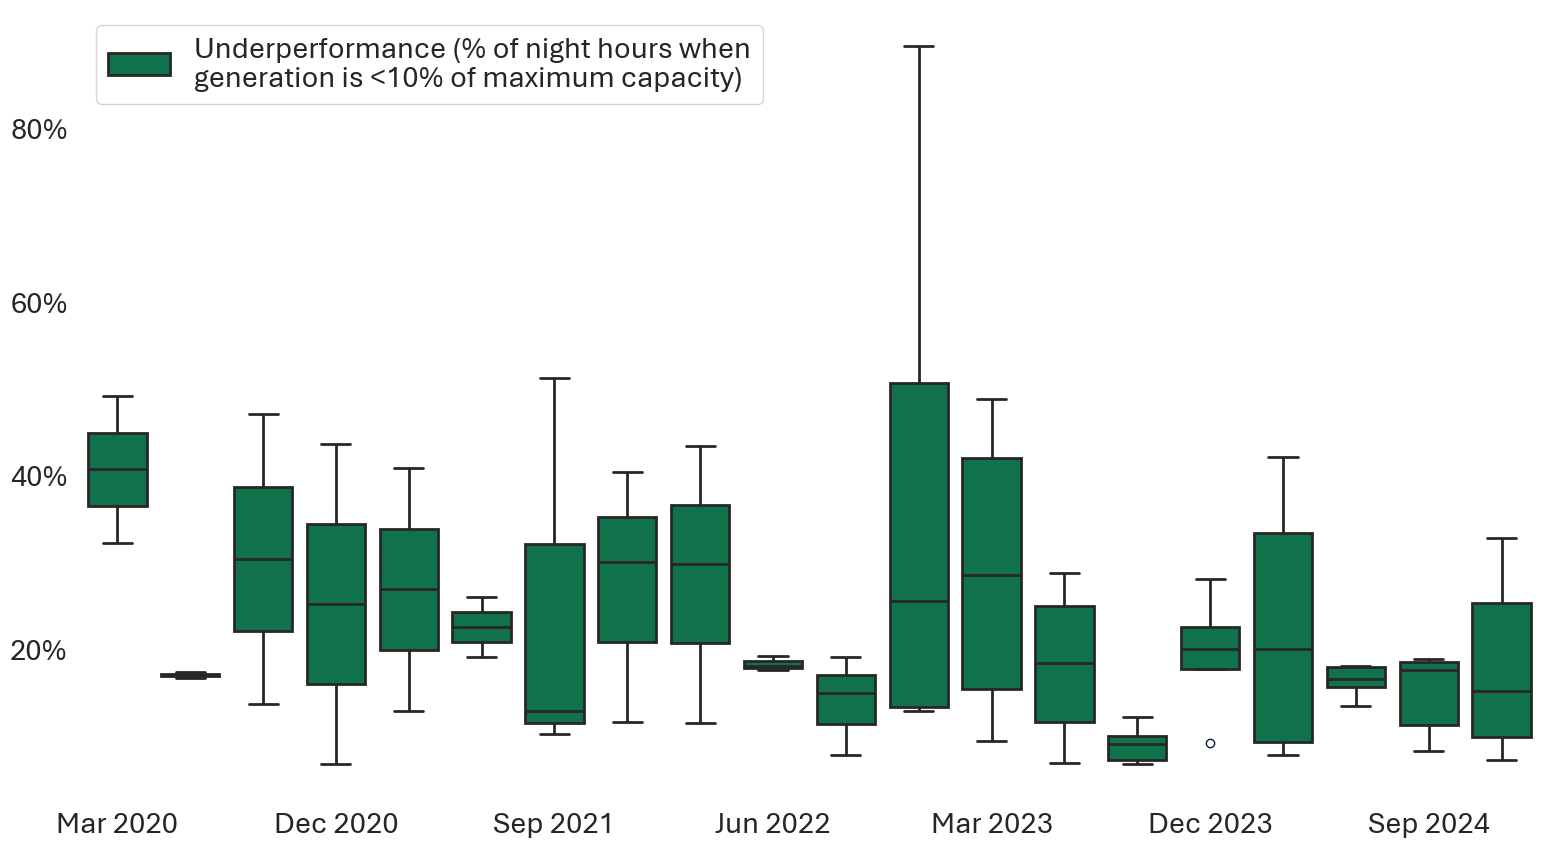

SA


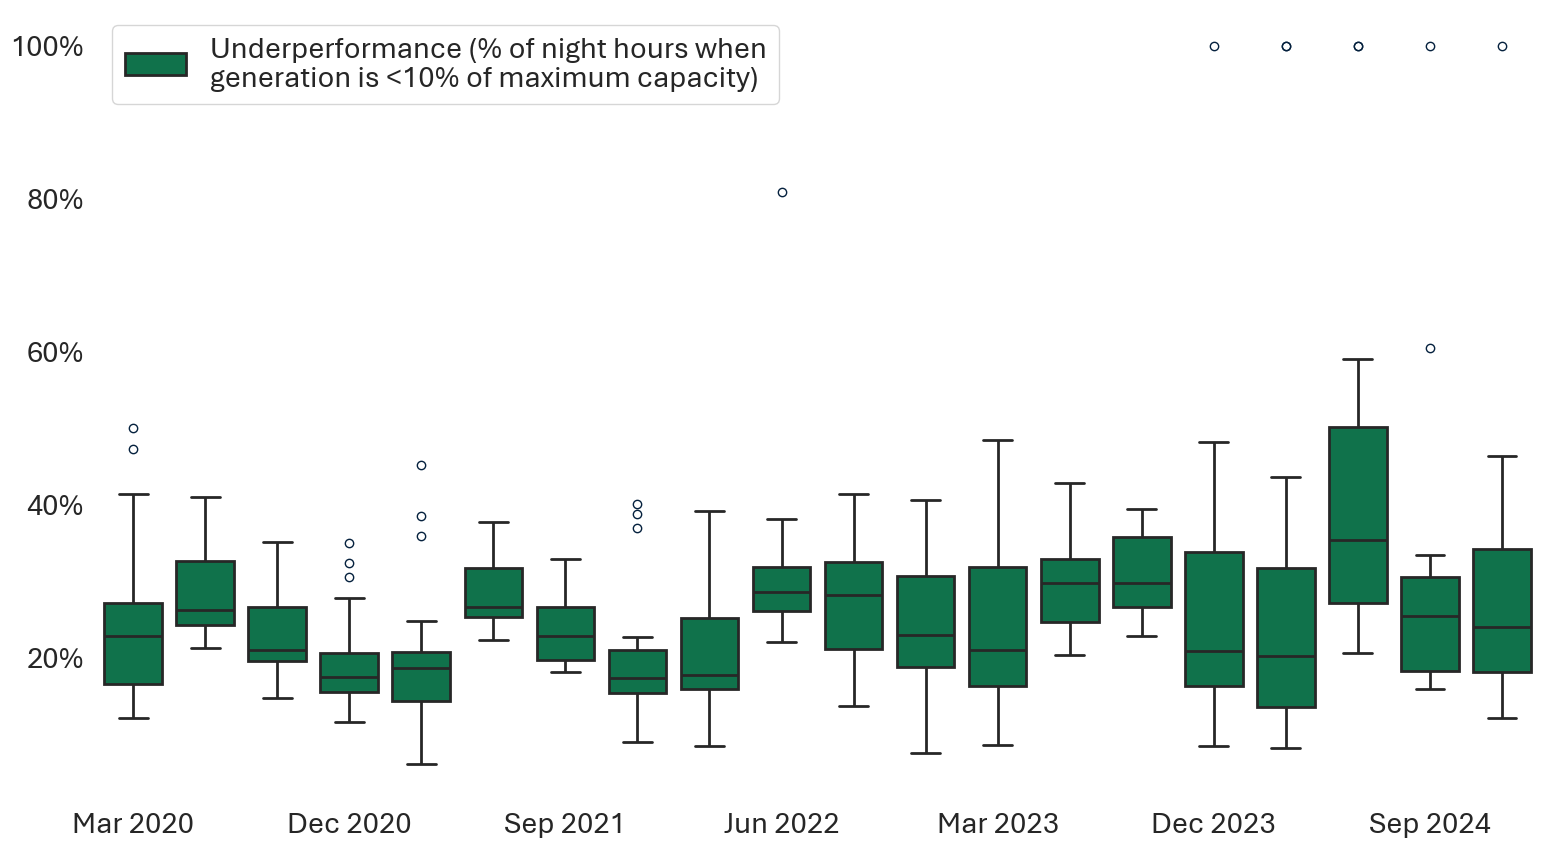

VIC


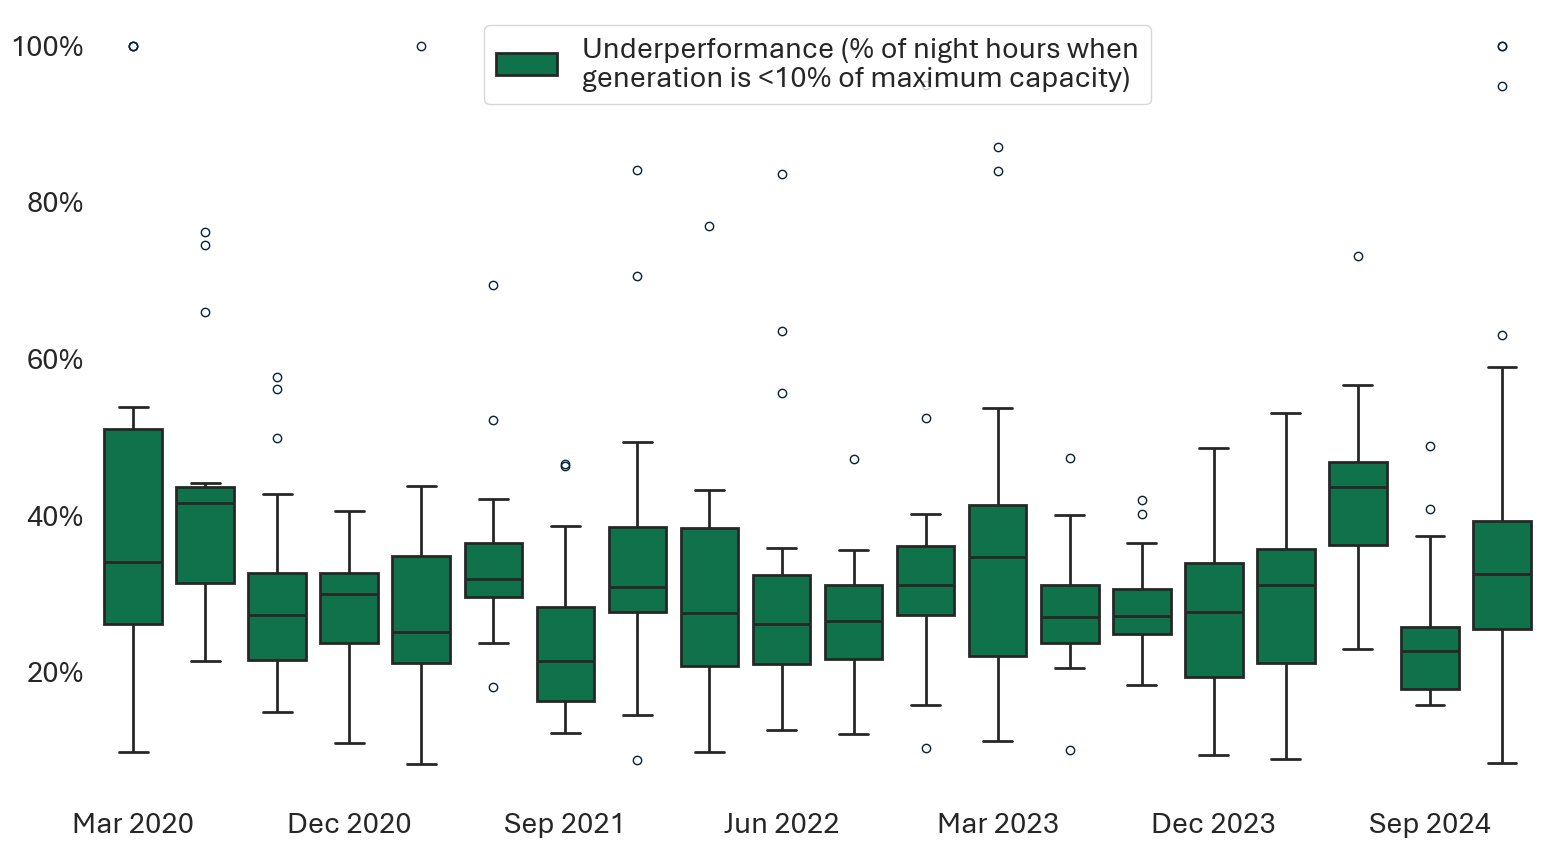

In [120]:
for i, region in enumerate(regions):
    print(region)
    region_duids = gen_info[
        (gen_info["Region"] == region) &
        (gen_info["Technology"] == "Wind")].index
    region_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["Interval", "DUID", "Output", "Maximum capacity"])
    region_data = region_data[
        (region_data["Interval"].dt.hour < 6) |
        (region_data["Interval"].dt.hour > 20) |
        ((region_data["Interval"].dt.hour == 20) &
         (region_data["Interval"].dt.minute > 0))]
    region_data["Underperformance"] = region_data["Output"] < (region_data["Maximum capacity"] * 0.1)
    region_data = region_data.pivot_table(
        index="Interval",
        columns="DUID",
        values="Underperformance",
        aggfunc="sum")
    region_data = region_data.resample("QE").mean()
    region_data.index.name = "Quarter"
    quarters = region_data.index
    first_row = region_data.iloc[0]    
    # Filter out invalid sequences
    region_data_valid = region_data.shift(1).notna()
    region_data = region_data.where(region_data_valid)
    region_data.iloc[0] = first_row

    # Melt for boxplot
    box_data = region_data.reset_index().melt(
        id_vars="Quarter",
        var_name="DUID",
        value_name="Underperformance")
    region_data.to_csv(
        os.path.join(data_dir, f"{region}_duid_wind_underperformance_quarterly.csv"))

    # Create plot
    fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

    # Create boxplot
    sns.boxplot(
        ax=ax,
        data=box_data,
        x="Quarter",
        y="Underperformance",
        color="C2",
        linewidth=2,
        flierprops=dict(markeredgecolor="C0"),
        label="Underperformance (% of night hours when\ngeneration is <10% of maximum capacity)")

    # Format axes
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0%}")

    # Clean up
    for frame in ["top", "right", "bottom", "left"]:
        ax.spines[frame].set_visible(False)

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    plt.show()
    save_figure(fig, f"{region}_duid_wind_quarterly_underperformance", charts_dir)